## Imports

In [492]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings

import scipy.stats as stats
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import root_mean_squared_error, mean_squared_error, make_scorer
from sklearn.model_selection import  cross_val_score, KFold

from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans

## Setup

In [493]:
PATH_TRAIN = 'datasets/train.csv'
PATH_TEST = 'datasets/test.csv'

pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 300)

exibe_logs = False    # Controla a exibição de logs (display_logs)

pd.options.display.float_format = '{:.4f}'.format
warnings.filterwarnings('ignore')


palete = sns.color_palette("Paired")

# coluna preenchinda no métogo get_dataframe()
colunas_numericas = list()

colunas_categoricas = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'GarageCond', 
                       'GarageQual', 'GarageFinish', 'KitchenQual', 'ExterQual', 'ExterCond', 'HeatingQC', 
                       'Functional', 'Utilities', 'LandSlope', 'LandContour', 'LotShape',
                       'LotConfig', 'PavedDrive', 'CentralAir', 'Alley', 'Electrical']

colunas_para_transformacao_ohe = ['MSSubClass', 'MSZoning', 'Neighborhood', 'Condition1', 'Condition2', 
                                    'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
                                    'MasVnrType', 'Foundation', 'Heating', 'GarageType', 'SaleType', 'SaleCondition',
                                    'BsmtFinType2', 'BsmtFinType2']

# coluna preenchida no método de processamento das colunas One Hot Encoding
colunas_transformadas_ohe = list()

# armazena todas as features criadas no processo de feature engeneering
features_criadas = list()

# preenchido quando o método set_feature_importance() é chamado
feature_importance_cols = list()

features_fortemente_correlacionadas = list()


def adicionar_features_criadas(feature: str):
    global features_criadas
    features_criadas.append(features_criadas) if feature not in features_criadas else print(f"a feature {feature} já existe")

def remover_feature_criada(feature: str):
    global features_criadas
    features_criadas.remove(feature) if feature in features_criadas else print(f"Feature {feature} não existe")

def adicionar_caracteristicas_fortemente_correlacionadas(feature: str):
    global features_fortemente_correlacionadas
    features_fortemente_correlacionadas.append(feature) if feature not in features_fortemente_correlacionadas else print(f"Feature {feature} já existe")


def remover_feature_fortemente_correlacionada(feature: str):
    global features_fortemente_correlacionadas
    features_fortemente_correlacionadas.remove(feature) if feature in features_fortemente_correlacionadas else print(f"Feature {feature} não existe")

## Funções de tratamento e processamento de dados

### Processamento de dados

In [494]:
def display_logs(log):
    if exibe_logs:
        print(f'*** {log} ***')

In [495]:
def get_dataframe(path: str) -> pd.DataFrame:
    dataframe = pd.read_csv(path)
    return dataframe

In [496]:
def obter_validacao_e_testes_concatenados():
    df_treino = get_dataframe(path=PATH_TRAIN)
    df_teste = get_dataframe(path=PATH_TEST)
    df = pd.concat([df_treino, df_teste], sort=False)
    return df

In [497]:
def separar_dataframes_validacao_e_testes(dataframe: pd.DataFrame):
    validacao = dataframe.iloc[:1460]
    testes = dataframe.iloc[1460: ]
    return validacao, testes

In [498]:
def checar_existencia_valores_nulos(dataframe: pd.DataFrame, min_index: int = 0, max_index: int = 100) -> pd.DataFrame:
    colunas_com_valores_nulos = dataframe.columns[dataframe.isna().any()]
    df = dataframe[colunas_com_valores_nulos].isna().sum()
    df = df.iloc[min_index:max_index]
    df = df.sort_values(ascending=False)
    print("\n######## COLUNAS COM VALORES NULOS ########\n")
    print(df)

### Funções de tratamento de dados ausentes


In [499]:
def preencher_com_moda(series):
    if series.isna().all():
        return series  # Retorna a série como está se todos os valores são nulos
    mode_value = series.mode()[0] if not series.mode().empty else series
    return series.fillna(mode_value)

In [500]:
def processar_alley(dataframe: pd.DataFrame, operacao: int = 1) -> pd.DataFrame:
    if operacao == 0:
        dataframe.pop('Alley')
        display_logs("A coluna Alley foi removida.")
    else:
        qtd = dataframe.Alley.isna().sum()
        dataframe.fillna({'Alley': 'NA'}, inplace=True)
        display_logs(f"Alley - {qtd} valores nulos preenchidos com a string NA")
    return dataframe

In [501]:
def processar_pool_qc(dataframe: pd.DataFrame, deletar: bool = True) -> pd.DataFrame:   
    if deletar:
        dataframe = dataframe.drop(columns=['PoolQC'])
    else:
        condicao_pool_area = dataframe['PoolArea'] == 0
        dataframe['PoolQC'] = dataframe.PoolQC.mask(condicao_pool_area, 'NA')
        qtd_registros_vazios = dataframe.PoolQC.isna().sum()
        display_logs(f"PoolQC - {qtd_registros_vazios} registros preenchidos com NA")
        
        if qtd_registros_vazios > 0:
            categorical = ['PoolQC']
            numerical = ['OverallQual', 'PoolArea', 'LotArea']
            qtd_registros_vazios = dataframe.PoolQC.isna().sum()
            dataframe = dataframe['PoolQC'].fillna(dataframe['PoolQC'].mode()[0])
            display_logs(f"PoolQC - {qtd_registros_vazios} valores residuais preenchidos com KNN")
        
    return dataframe

In [502]:
def processar_misc_feature(dataframe: pd.DataFrame) -> pd.DataFrame:   
    qtd_nulos = dataframe.MiscFeature.isna().sum()
    dataframe['MiscFeature'] = dataframe.MiscFeature.fillna("NA")
    display_logs(f"MiscFeature - {qtd_nulos} valores nulos com a string NA")
    return dataframe

In [503]:
def processar_fence(dataframe: pd.DataFrame) -> pd.DataFrame:   
    dataframe['Fence'] = dataframe.Fence.fillna("NA")
    qtd_nulos = dataframe.MiscFeature.isna().sum()
    display_logs(f"Fence - {qtd_nulos} valores nulos com a string NA")
    return dataframe

In [504]:
def processar_mas_vn_area(dataframe: pd.DataFrame) -> pd.DataFrame:   
    qtd_nulos = dataframe.MiscFeature.isna().sum()
    dataframe['MasVnrArea'] = dataframe['MasVnrArea'].fillna(dataframe.MasVnrArea.mean())
    display_logs(f"MasVnrArea - {qtd_nulos} valores preenchidos com a média")
    
    return dataframe


In [505]:
def processar_mas_vnr_type(dataframe: pd.DataFrame) -> pd.DataFrame:   
    condition1 = dataframe['MasVnrArea'] == 0
    dataframe['MasVnrType'] = dataframe['MasVnrType'].mask(condition1, 'None')

    qtd_nulos = dataframe.MasVnrType.isna().sum()

    display_logs(f"MasVnrType - {qtd_nulos} valores nulos com a string NA se o valor de MasVnrArea for igual a 0")
    return dataframe


In [506]:
def processar_fireplace(dataframe: pd.DataFrame, operacao: int = 0) -> pd.DataFrame:   
    if operacao == 0:
        
        dataframe.drop(columns=['FireplaceQu'], inplace=True)
        display_logs(f"FireplaceQu - removida")

        return dataframe
        
    else:
        condicao_fireplaces = dataframe['Fireplaces'] == 0
        qtd_fireplaces_zerados = dataframe.FireplaceQu.isna().sum()
        
        # Preenchendo com NA linhas em que não há FireplaceQu
        dataframe['FireplaceQu'] = dataframe.PoolQC.mask(condicao_fireplaces, 'NA')
        display_logs(f"FireplaceQu - {qtd_fireplaces_zerados} valores preenchidos com NA porque o valorde Fireplaces é 0")

        # Preenchendo valores residuais com a moda
        qtde_nulos = dataframe['FireplaceQu'].isna().sum()
        if qtde_nulos > 0:
            dataframe['FireplaceQu'] = dataframe.groupby(by=['OverallQual', 'OverallCond', 'YearBuilt', 'HouseStyle'])['FireplaceQu'].transform(preencher_com_moda)
            display_logs(f"FireplaceQu - {qtde_nulos} valores preenchidos com a moda")
        
        return dataframe

In [507]:
def processar_garagens(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    condicao = dataframe.GarageArea == 0
    
    # Preenchendo colunas com NA se não houver garagem
    qtd_nulos = dataframe[dataframe.GarageArea == 0].shape[0]
    dataframe[['GarageQual', 'GarageCond', 'GarageFinish', 'GarageType']] = dataframe[['GarageQual', 'GarageCond', 'GarageFinish', 'GarageType']].mask(condicao, 'NA')
    display_logs(f" ['GarageQual', 'GarageCond', 'GarageFinish', 'GarageType'] - {qtd_nulos} valores preenchidos com NA porque a aréa da garagem é 0")

    dataframe[['GarageCars']] = dataframe[['GarageCars']].mask(condicao, 0)
    dataframe[['GarageYrBlt']] = dataframe[['GarageYrBlt']].mask(condicao, 1900)
    display_logs(f"['GarageYrBlt', 'GarageCars'] - {qtd_nulos} registros preenchidos com 0 porque GarageArea é 0")

    # Preenchendo valores residuais para campos nulos com área de garagem maior do que 0
    dataframe['GarageArea'] = dataframe['GarageArea'].fillna(dataframe.GarageArea.mean())
    dataframe['GarageYrBlt'] = dataframe['GarageYrBlt'].fillna(dataframe.GarageYrBlt.mode()[0])
    dataframe['GarageFinish'] = dataframe['GarageFinish'].fillna(dataframe.GarageFinish.mode()[0])
    dataframe['GarageCars'] = dataframe['GarageCars'].fillna(dataframe.GarageCars.mode()[0])
    
    dataframe['GarageQual'] = dataframe.groupby(by=['OverallQual'])['GarageQual'].transform(preencher_com_moda)
    dataframe['GarageCond'] = dataframe.groupby(by=['OverallQual', 'OverallCond'])['GarageCond'].transform(preencher_com_moda)
    
    
    return dataframe

In [508]:
def preencher_valores_residuais_de_bsmt(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    dataframe['bsmt_area_cat'] = pd.qcut(dataframe['TotalBsmtSF'], q=5, labels=False)
    
    # Lista de colunas a serem preenchidas
    cols_to_fill = ['BsmtCond', 'BsmtExposure', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1', 
                        'OverallQual', 'bsmt_area_cat', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 
                        'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath']

    # Aplicar o preenchimento com a moda para cada coluna
    for col in cols_to_fill:
        dataframe[col] = dataframe.groupby(by=['OverallQual', 'bsmt_area_cat'])[col].transform(preencher_com_moda)

        # Preencher qualquer valor restante com a moda global da coluna
        dataframe[col] = dataframe[col].fillna(dataframe[col].mode()[0])
    
    dataframe = dataframe.drop(columns=['bsmt_area_cat'])

    return dataframe

In [509]:
def processar_basement(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    condicao1 = dataframe['TotalBsmtSF'] == 0

    cols = ['BsmtCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
    dataframe[cols] = dataframe[cols].mask(condicao1, 'NA')
    area_quadrada_nulos = dataframe.TotalBsmtSF.isna().sum()
    display_logs(f"['BsmtCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'] - {area_quadrada_nulos} registros preenchidos com NA se TotalBsmtSF igual a 0")

    cols_bsmt_numericas = ['BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF']
    dataframe[cols_bsmt_numericas] = dataframe[cols_bsmt_numericas].mask(condicao1, 0)

    dataframe = preencher_valores_residuais_de_bsmt(dataframe=dataframe)

    return dataframe

In [510]:
def processar_electrical(dataframe: pd.DataFrame) -> pd.DataFrame:
    qtd_nulos = dataframe['Electrical'].isna().sum()
    moda = dataframe['Electrical'].mode()[0]  # Pega o primeiro valor da moda
    dataframe['Electrical'] = dataframe['Electrical'].fillna(moda)
    display_logs(f"Electrical: {qtd_nulos} valores nulos processados com a moda '{moda}'")
    return dataframe

In [511]:
def processar_lot_frontage_regulares_ms_zoning_fv(dataframe: pd.DataFrame) -> pd.DataFrame:
    lotes_regulares = dataframe.copy()
    lotes_regulares['sqrt_lote_area'] = np.sqrt(lotes_regulares['LotArea'])
    
    lotes_regulares_ms_zoning_fv = lotes_regulares[lotes_regulares['MSZoning'] == 'FV']
    lotes_regulares_ms_zoning_fv_vlr_nulos = lotes_regulares_ms_zoning_fv[lotes_regulares_ms_zoning_fv['LotFrontage'].isna()]
    
    lotes_regulares_ms_zoning_fv = lotes_regulares_ms_zoning_fv.drop(lotes_regulares_ms_zoning_fv_vlr_nulos.index)
    
    X = lotes_regulares_ms_zoning_fv[['sqrt_lote_area', 'OverallQual', 'OverallCond']]
    y = lotes_regulares_ms_zoning_fv['LotFrontage']

    estimator = LinearRegression()
    estimator.fit(X, y)

    # Previsão dos valores nulos
    X_nulos = lotes_regulares_ms_zoning_fv_vlr_nulos[['sqrt_lote_area', 'OverallQual', 'OverallCond']]
    y_pred = estimator.predict(X_nulos)

    # Converte y_pred para uma Série Pandas com o mesmo índice dos nulos
    y_pred_series = pd.Series(y_pred, index=lotes_regulares_ms_zoning_fv_vlr_nulos.index)

    # Atribui os valores previstos de volta ao DataFrame original
    dataframe.loc[lotes_regulares_ms_zoning_fv_vlr_nulos.index, 'LotFrontage'] = y_pred_series

    display_logs(f"processar_lot_frontage_regulares_ms_zoning_fv: {lotes_regulares_ms_zoning_fv_vlr_nulos.shape[0]} registros processados")

    return dataframe


In [512]:
def processar_lot_frontage_lotconfig_Reg_FR2_FR3_CulDSac(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    df = dataframe.copy()

    # Adicionando a propriedade sqrt_lote_area, caso não exista
    if 'sqrt_lote_area' not in df.columns:
        df['sqrt_lote_area'] = np.sqrt(df['LotArea'])
    
    # Aplicando filtro de linhas
    linhas_filtradas = df[(df.LotShape == 'Reg') & (df.LotConfig.isin(['FR2', 'FR3', 'CulDSac']))]

    # Criando variável com linhas que serão preenchidas pelo algoritmo
    linhas_com_lot_frontage_nulo = linhas_filtradas[linhas_filtradas.LotFrontage.isna()]
    
    # Removendo linhas vazias do X
    X = linhas_filtradas.dropna(subset=['LotFrontage'])
    
    # Criando o y da regressão
    y = X['LotFrontage']
    X = X[['sqrt_lote_area', 'OverallQual', 'OverallCond']]

    # Treinando o modelo
    estimator = LinearRegression()
    estimator.fit(X, y)

    # Previsão dos valores nulos
    y_pred = np.array(estimator.predict(linhas_com_lot_frontage_nulo[['sqrt_lote_area', 'OverallQual', 'OverallCond']]), dtype=np.float64)

    # Redefinir índices
    df = df.reset_index(drop=True)
    linhas_com_lot_frontage_nulo = linhas_com_lot_frontage_nulo.reset_index(drop=True)

    # Atribuir valores
    try:
        df.loc[linhas_com_lot_frontage_nulo.index, 'LotFrontage'] = y_pred
    except ValueError:
        print("Atribuição falhou com df.loc, tentando com iloc.")
        df.iloc[linhas_com_lot_frontage_nulo.index, df.columns.get_loc('LotFrontage')] = y_pred

    display_logs(f"processar_lot_frontage_lotconfig_Reg_FR2_FR3_CulDSac: {linhas_com_lot_frontage_nulo.shape[0]} registros processados")

    return df


In [513]:
def processar_lot_frontage_lotconfig_Reg_2Story_SFoyer_SLvl(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    # Adicionando a propriedade sqrt_lote_area, caso não exista
    if 'sqrt_lote_area' not in dataframe.columns:
        dataframe['sqrt_lote_area'] = np.sqrt(dataframe['LotArea'])
    
    # Aplicando filtro de linhas
    linhas_filtradas = dataframe[((dataframe.LotShape == 'Reg') & ( (dataframe.HouseStyle == '2Story') | (dataframe.HouseStyle == 'SFoyer') | (dataframe.HouseStyle == 'SLvl')  ) ) ]

    # Criando variável com linhas que serão preenchidas pelo algoritmo
    linhas_com_lot_frontage_nulo = linhas_filtradas[linhas_filtradas.LotFrontage.isna()]
    
    # Removendo linhas vazias do X
    X = linhas_filtradas.drop(linhas_com_lot_frontage_nulo.index)
    
    # Criando o y da regressão
    y = X['LotFrontage']

    # Treinando o modelo
    estimator = LinearRegression()
    estimator.fit(X[['sqrt_lote_area']], y)

    # Previsão dos valores nulos
    y_pred = estimator.predict(linhas_com_lot_frontage_nulo[['sqrt_lote_area']])

    # Preenche os valores previstos de volta no DataFrame original
    dataframe.loc[linhas_com_lot_frontage_nulo.index, 'LotFrontage'] = y_pred

    display_logs(f"processar_lot_frontage_lotconfig_Reg_2Story_SFoyer_SLvl: {linhas_com_lot_frontage_nulo.shape[0]} registros processados")

    return dataframe

In [514]:
def processar_lot_frontage_residual(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe.fillna({'LotFrontage': dataframe.LotFrontage.mean()}, inplace=True)
    display_logs("LotFrontage: Processando valores residuais com a média")

    dataframe = dataframe.drop(columns=['sqrt_lote_area'])
    display_logs("sqrt_lote_area: coluna removida no método processar_lot_frontage_residual")

    return dataframe

In [515]:
def processar_utilities(dataframe: pd.DataFrame) -> pd.DataFrame:

    df = dataframe.copy()
    qtde_nulos = df.Utilities.isna().sum()
    
    if qtde_nulos > 0:
        df['Utilities'] = df.groupby(by=['MSZoning', 'OverallQual'])['Utilities'].transform(preencher_com_moda)
        display_logs(f'Utilities: {qtde_nulos} registros preenchidos com a moda.')

        # Preenchendo valores residuais, caso existam
        df['Utilities'] = df['Utilities'].fillna(df['Utilities'].mode()[0])

    return df

In [516]:
def processar_functional(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    qtde_nulos = dataframe.Functional.isna().sum()
    
    if qtde_nulos > 0:
        dataframe['Functional'] = dataframe['Functional'].fillna(dataframe['Functional'].mode()[0])
        display_logs(f'Functional: {qtde_nulos} registros preenchidos com KNN')

    return dataframe

In [517]:
def processar_kitchen_qual(dataframe: pd.DataFrame) -> pd.DataFrame:
    qtde_nulos = dataframe.KitchenQual.isna().sum()
    dataframe['KitchenQual'] = dataframe.groupby(by=['OverallQual', 'GrLivArea', 'KitchenAbvGr'])['KitchenQual'].transform(preencher_com_moda)
    display_logs(f'KitchenQual: {qtde_nulos} registros preenchidos com a moda')

    return dataframe

In [518]:
def processar_sale_type(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    qtde_nulos = dataframe.SaleType.isna().sum()
    
    if qtde_nulos > 0:
        dataframe['SaleType'] = dataframe['SaleType'].fillna(dataframe['SaleType'].mode()[0])
        display_logs(f'SaleType: {qtde_nulos} registros preenchidos com KNN')

    return dataframe

### Encodings

In [519]:
def processar_encodings_com_gradacao(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    d1 = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
    d2 = {'GLQ': 6, 'ALQ':  5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0}

    dataframe['BsmtQual'] = dataframe['BsmtQual'].replace(d1).astype('Int64')
    dataframe['BsmtCond'] = dataframe['BsmtCond'].replace(d1).astype('Int64')
    dataframe['BsmtExposure'] = dataframe['BsmtExposure'].replace({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}).astype('Int64') 
    # dataframe['BsmtFinType1'] = dataframe['BsmtFinType2'].replace(d2).astype('Int64')  
    # dataframe['BsmtFinType2'] = dataframe['BsmtFinType2'].replace(d2).astype('Int64')
    
    dataframe['GarageCond'] = dataframe['GarageCond'].replace(d1).astype('Int64')
    dataframe['GarageQual'] = dataframe['GarageQual'].replace(d1).astype('Int64')
    dataframe['GarageFinish'] = dataframe['GarageFinish'].replace({'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0}).astype('Int64')
    
    dataframe['KitchenQual'] = dataframe['KitchenQual'].replace(d1).astype('Int64')
    dataframe['ExterQual'] = dataframe['ExterQual'].replace(d1).astype('Int64')
    dataframe['ExterCond'] = dataframe['ExterCond'].replace(d1).astype('Int64')
    
    dataframe['HeatingQC'] = dataframe['HeatingQC'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}).astype('Int64')
    dataframe['Functional'] = dataframe['Functional'].replace({'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1}).astype('Int64')
    dataframe['Utilities'] = dataframe['Utilities'].replace({'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1}) 


    # Os atributos abaixo podem ser processados com One-Hot Encoding, caso necessário.
    dataframe['LandSlope'] = dataframe['LandSlope'].replace({'Gtl': 3, 'Mod': 2, 'Sev': 1}).astype('Int64')
    dataframe['LandContour'] = dataframe['LandContour'].replace({'Lvl': 4, 'Bnk': 3, 'HLS': 2, 'Low': 1}).astype('Int64')
    dataframe['LotShape'] = dataframe['LotShape'].replace({'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1}).astype('Int64')
    dataframe['LotConfig'] = dataframe['LotConfig'].replace({'CulDSac': 5, 'FR3': 4, 'Corner': 3, 'FR2': 2, 'Inside': 1}).astype('Int64') 
    dataframe['PavedDrive'] = dataframe['PavedDrive'].replace({'Y': 3, 'P': 2, 'N': 1}).astype('Int64')
    dataframe['CentralAir'] = dataframe['CentralAir'].replace({'Y': 1, 'N': 0}).astype('Int64')
    dataframe['Alley'] = dataframe['Alley'].replace({'Grvl': 2, 'Pave': 1, 'NA': 0}).astype('Int64')
    dataframe['Electrical'] = dataframe['Electrical'].replace({'SBrkr': 5, 'FuseA': 4, 'Mix': 3, 'FuseF': 2, 'FuseP': 1}).astype('Int64')
    

    # Colunas removidas porque não terão utilidade, dado que estas colunas são muito desbalanceadas e temos colunas mais importantes para trabalhar.         
    # dataframe['PoolQC'] = dataframe['PoolQC'].replace({'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'NA': 0}).astype('Int64')
    # dataframe['FireplaceQu'] = dataframe['FireplaceQu'].replace(d1).astype('Int64')
    # dataframe['Street'] = dataframe['Street'].replace({'Grvl': 1, 'Pave': 2}).astype('Int64')

    display_logs("Processando encodings com gradação ...")

    return dataframe

In [520]:
def processar_one_hot_encoding(dataframe: pd.DataFrame, columns_to_ohe: list) -> pd.DataFrame:
    # Armazena as colunas originais
    colunas_originais = set(dataframe.columns)

    # Converte as colunas selecionadas para o tipo 'category'
    for feature in columns_to_ohe:
        dataframe[feature] = dataframe[feature].astype('category')
    
    # Aplica o One Hot Encoding
    df_encoded = pd.get_dummies(data=dataframe, columns=columns_to_ohe, drop_first=True)

    # Armazena as colunas após a transformação
    colunas_apos_transformacao = set(df_encoded.columns)

    # Identifica as colunas adicionadas
    global colunas_transformadas_ohe
    colunas_transformadas_ohe = list(colunas_apos_transformacao - colunas_originais)

    # Converte colunas booleanas para inteiros
    for col in df_encoded.select_dtypes(include=['bool']).columns:
        df_encoded[col] = df_encoded[col].astype(int)

    # Exibe logs
    display_logs(f"One Hot Encoding processado para: {columns_to_ohe}")
    
    return df_encoded


### Criação de Features

In [521]:
def adicionar_features_de_area(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    # a área total influencia no preço de venda?
    dataframe['total_area'] = dataframe['GrLivArea'] + dataframe['TotalBsmtSF']

    # A área total de varanda influencia no preço?
    # dataframe['total_area_porch'] = dataframe['OpenPorchSF'] + dataframe['EnclosedPorch'] + dataframe['3SsnPorch'] + dataframe['WoodDeckSF']

    # A relação entre a área de varanda e área total construída influencia no preço de venda?
    dataframe['porch_total_area_per_total_area'] = dataframe[['total_area', 'total_area_porch']].apply(lambda x: x[1] / x[0] if x[1] > 0 else 0, axis=1)

    # a proporção da área construída influencia no preço de venda? 
    dataframe['total_area_per_lote_area'] = dataframe['total_area'] / dataframe['LotArea']    

    display_logs("Criação das features ['total_area', 'total_area_porch', 'porch_total_area_per_total_area', 'total_area_per_lote_area']")

    return dataframe

In [522]:
def adicionar_features_rooms(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    # O total de banheiros e lavabos tem influência sobre o preço de venda?
    dataframe['total_full_half_bathroom_ponderados'] = dataframe['FullBath'] + 0.5 * dataframe['HalfBath'] + dataframe['BsmtFullBath'] + 0.5 * dataframe['BsmtHalfBath']

    # e o total de cômodos?
    dataframe['total_rooms'] = dataframe['TotRmsAbvGrd'] + dataframe['FullBath'] + dataframe['HalfBath'] + dataframe['BsmtFullBath'] + dataframe['BsmtHalfBath']

    # A relação entre quartos e o total de cômodos influência no preço de venda?
    dataframe['bedroom_per_room'] = dataframe['BedroomAbvGr'] / dataframe['TotRmsAbvGrd']

    # avaliando o tamanho médio dos cômodos acima do solo
    dataframe['average_room_abv'] = dataframe['GrLivArea'] / dataframe['total_rooms']

    display_logs("Criação das features ['total_full_half_bathroom_ponderados', 'total_rooms', 'bedroom_per_room', 'average_room_abv']")

    return dataframe

In [523]:
def adicionar_feature_qualidade(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Como as duas variáveis juntas influenciam no valor do imóvel? A variável multiplicada pelo seu índice dividido pela soma dos índices
    dataframe['index_qual_cond'] = (dataframe['OverallQual']*10 + dataframe['OverallCond']*10 + dataframe['ExterQual']*5 + dataframe['ExterCond']*5) / 30
    dataframe['index_qual_bsmt'] = ((dataframe['BsmtQual']*6 + dataframe['BsmtCond']*6 + dataframe['BsmtExposure']*5 + dataframe['BsmtFinType1']*7 + dataframe['BsmtFinType2']*7) / 29)
    dataframe['index_garage_qual_cond'] = dataframe['GarageQual'] + dataframe['GarageCond']

    # Relação entre os métros quadrados por qualidade
    dataframe['gr_liv_area_per_overall_qual'] = (dataframe['GrLivArea'] / np.exp2(dataframe['OverallQual']))
    dataframe['total_bsmt_per_qual'] = dataframe['TotalBsmtSF'] / np.exp2(dataframe['BsmtQual'])
    dataframe['garage_area_per_qual'] = dataframe[['GarageArea', 'GarageQual']].apply(lambda x: x[0] / x[1] if x[1] > 0 else 0, axis=1)

    dataframe['index_total_area_per_overallqual'] = dataframe['total_area'] / dataframe['OverallQual']

    # dataframe['index_gr_liv_area_complex'] = (dataframe['GrLivArea'] * dataframe['ExterQual'] * dataframe['OverallQual']) + dataframe['BsmtQual'] * dataframe['BsmtCond'] + dataframe['GarageQual'] * dataframe['GarageCond'] + dataframe['KitchenAbvGr'] * dataframe['KitchenQual']


    display_logs("Criação das features ['index_gr_liv_area_complex', 'index_qual_cond', 'index_qual_bsmt', 'index_garage_qual_cond', 'gr_liv_area_per_overall_qual', 'total_bsmt_per_qual', 'garage_area_per_qual', 'index_total_area_per_overallqual']")
    
    return dataframe

In [524]:
def adicionar_atributos_idade(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['age_house'] = dataframe[['YrSold', 'YearBuilt']].apply(lambda x: x[0] - x[1] if x[0] != x[1] else 0.1, axis=1)
    dataframe['age_remode'] = dataframe[['YrSold', 'YearRemodAdd', 'age_house']].apply(lambda x: x[0] - x[1] if (x[0] != x[1] and x[1] > 0) else x[2], axis=1)
    
    display_logs("Criação das features ['age_house', 'age_remode']")

    return dataframe

In [525]:
def adicionar_features_diversas(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    dataframe['index_degree_qual_year'] = dataframe[['OverallQual', 'OverallCond', 'age_house']].apply(lambda x: np.nan_to_num((x[0] + x[1])/x[2]), axis=1)
    dataframe['index_degree_qual_since_Remode'] = dataframe[['OverallQual', 'OverallCond', 'age_remode', 'age_house']].apply(lambda x: np.nan_to_num((x[0] + x[1])/np.sqrt(x[2] if x[2] > 0 else x[3])), axis=1)

    dataframe['has_elevator'] = dataframe['MiscFeature'].apply(lambda x: 1 if x == 'Elev' else 0)
    dataframe['has_gar2'] = dataframe['MiscFeature'].apply(lambda x: 1 if x == 'Gar2' else 0)
    dataframe['has_shed'] = dataframe['MiscFeature'].apply(lambda x: 1 if x == 'Shed' else 0)
    dataframe['has_tenc'] = dataframe['MiscFeature'].apply(lambda x: 1 if x == 'TenC' else 0)
    # dataframe['has_pool'] = dataframe['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

    dataframe['has_1st_floor'] = dataframe['1stFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    dataframe['has_2nd_floor'] = dataframe['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    dataframe['has_bsmt'] = dataframe[['BsmtFinSF1', 'BsmtFinSF2']].apply(lambda x: 1 if x[0] > 0 or x[1] > 0 else 0, axis=1)

    display_logs("Criação das features ['index_degree_qual_year', 'index_degree_qual_since_Remode', 'has_elevator', 'has_gar2', 'has_shed', 'has_tenc', 'has_1st_floor', 'has_2nd_floor', 'has_bsmt', 'has_pool']")


    return dataframe

In [526]:
# Método utilizado para contabilizar a quantidade de itens especiais que a propriedade possui. 
def adicionar_itens_especiais(dataframe: pd.DataFrame) -> pd.DataFrame:
    cols = [['has_elevator', 'has_gar2', 'has_shed', 'has_tenc', 'has_pool', 'has_2nd_floor', 'has_bsmt']]
    dataframe['itens_especiais'] = dataframe[['has_elevator', 'has_gar2', 'has_shed', 'has_tenc', 'has_pool']].sum(axis=1)
    display_logs("Criação de Feature ['itens_especiais']")
    return dataframe

In [527]:
def criar_cat_quality(row):
    if row[0] == 10 and row[1] == 10 and row[2] == 10:
        return 5
    elif (row[0] == 9 or row[0] == 8) and (row[1] == 9 or row[1] == 8) and (row[2] == 9 or row[2] == 8):
        return 4
    elif (row[0] >= 5 and row[0] <= 7) and (row[1] >= 5 and row[1] <= 7) and (row[2] >= 5 and row[2] <= 7):
        return 3
    elif (row[0] >= 3 and row[0] <= 4) and (row[1] >= 3 and row[1] <= 4) and (row[2] >= 3 and row[2] <= 4):
        return 2
    elif (row[0] >= 1 and row[0] <= 3) and (row[1] >= 1 and row[1] <= 3) and (row[2] >= 1 and row[2] <= 3):
        return 1
    else:
        return 0
    

In [528]:
def adicionar_categoria_de_qualidade(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['cat_total_area'] = pd.qcut(dataframe['total_area'], q=10, labels=range(1, 11)).astype(int)
    dataframe['cat_quality'] = dataframe[['OverallQual', 'OverallCond', 'cat_total_area']].apply(criar_cat_quality, axis=1)
    dataframe = dataframe.drop(columns=['cat_total_area'])
    
    display_logs("Criação das feature ['cat_quality']")


    return dataframe 

In [529]:
def adicionar_combinacao_categorias(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    le = LabelEncoder()

    dataframe['lot_shape_config'] = dataframe[['LotShape', 'LotConfig']].apply(lambda x: str(x[0]) + "_" + str(x[1]), axis=1)
    dataframe['land_slop_contour'] = dataframe[['LandContour', 'LandSlope']].apply(lambda x: str(x[0]) + "_" + str(x[1]), axis=1)
    dataframe['slop_land'] = dataframe[['lot_shape_config', 'land_slop_contour']].apply(lambda x: str(x[0]) + "_" + str(x[1]), axis=1)

    dataframe['mszoning_utilities'] = dataframe[['MSZoning', 'Utilities']].apply(lambda x: str(x[0]) + "_" + str(x[1]), axis=1)

    dataframe['lot_shape_config'] = le.fit_transform(dataframe['lot_shape_config'])
    dataframe['land_slop_contour'] = le.fit_transform(dataframe['land_slop_contour'])
    dataframe['slop_land'] = le.fit_transform(dataframe['slop_land'])
    dataframe['mszoning_utilities'] = le.fit_transform(dataframe['mszoning_utilities'])

    display_logs("Criação da feature ['lot_shape_config', 'land_slop_contour', 'slop_land', 'mszoning_utilities']")
    
    return dataframe

In [530]:
def adicionar_total_area_freq(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['total_area_freq'] = dataframe.groupby(by=['OverallQual'])['total_area'].transform('mean')
    display_logs("Criação da feature ['zona_tipo_residencia_freq']")
    return dataframe

In [531]:
def obter_dataframe_preco_metro_quadrado() -> pd.DataFrame:
    
    treino = get_dataframe(path=PATH_TRAIN)
    
    # Calcular a área total (substitua 'LotArea' pelo nome da coluna correta)
    if 'total_area' not in treino.columns:
        treino['total_area'] = treino['GrLivArea'] + treino['TotalBsmtSF']  
    
    # Calcular o preço por metro quadrado
    treino['preco_metro_quadrado'] = treino['SalePrice'] / treino['total_area']
    
    # Agrupar por bairro e calcular a média
    series_mean = treino.groupby(by=['Neighborhood'])['preco_metro_quadrado'].mean()
    
    # Transformar em DataFrame e ajustar o nome da coluna
    dataframe = pd.DataFrame(series_mean).reset_index()
    
    return dataframe


In [532]:
def adicionar_preco_metro_quadrado(dataframe: pd.DataFrame) -> pd.DataFrame:
    df_preco_metro_quadrado = obter_dataframe_preco_metro_quadrado()
    dataframe = pd.merge(left=dataframe, right=df_preco_metro_quadrado, how='left', on=['Neighborhood', 'Neighborhood'])
    display_logs("Feature adicionada: preco_metro_quadrado")
    return dataframe

In [533]:
def adicionar_cluster(dataframe: pd.DataFrame, colname: str, n_clusters: int = 4) -> pd.DataFrame:
    dataframe[f'{colname}_kmeans'] = KMeans(n_clusters=4, random_state=42).fit_predict(dataframe[['age_house']])
    display_logs("Feature adicionada: age_house_kmeans")
    return dataframe

In [534]:
def adicionar_mega_cluster(dataframe: pd.DataFrame) -> pd.DataFrame:
    df = dataframe.copy().drop(columns=['SalePrice'])
    df = processar_one_hot_encoding(dataframe=df, columns_to_ohe=colunas_para_transformacao_ohe)
    cols = df.select_dtypes(include=['number']).columns.to_list()
    df[cols] = MinMaxScaler().fit_transform(df[cols])
    dataframe['cluster_kmeans'] = KMeans(n_clusters=5, random_state=42).fit_predict(df[cols])
    dataframe['cluster_kmeans'] = dataframe['cluster_kmeans'].astype('int')
    display_logs("Feature adicionada: cluster_kmeans")
    return dataframe

In [535]:
def criar_smooth_target_encoding(dataframe: pd.DataFrame, target_col, cat_col, m=10):
    """
    Aplica target encoding suavizado a uma coluna categórica.

    Parâmetros:
    - dataframe: DataFrame contendo os dados.
    - target_col: Nome da coluna alvo (string).
    - cat_col: Nome da coluna categórica a ser codificada (string).
    - m: Parâmetro de suavização (valor padrão = 10).

    Retorna:
    - Uma Série com os valores codificados.
    """
    # Média geral da coluna alvo
    overall_mean = dataframe[target_col].mean()

    # Estatísticas por categoria
    category_stats = dataframe.groupby(cat_col)[target_col].agg(['mean', 'count'])

    # Cálculo do peso para cada categoria
    category_stats['weight'] = category_stats['count'] / (category_stats['count'] + m)

    # Cálculo do target encoding suavizado
    category_stats['smooth_encoded'] = (
        category_stats['weight'] * category_stats['mean'] + 
        (1 - category_stats['weight']) * overall_mean
    )

    # Mapeamento dos valores codificados de volta ao DataFrame original
    dataframe[cat_col].map(category_stats['smooth_encoded'])

    display_logs(f"Criação de target encoding baseado em {cat_col}")

    return dataframe

In [536]:
def remover_outliers_zscore(dataframe: pd.DataFrame, col, threshold=3) -> pd.DataFrame:
    """
    Remove outliers de um DataFrame com base no z-score de uma coluna específica.

    Parâmetros:
    df (pd.DataFrame): DataFrame contendo os dados.
    col (str): Nome da coluna que será usada para calcular os z-scores.
    threshold (float): Limite para considerar um valor como outlier. O padrão é 3.

    Retorna:
    pd.DataFrame: DataFrame sem os outliers.
    """
    # Calcula os z-scores da coluna especificada
    z_scores = np.abs((dataframe[col] - dataframe[col].mean()) / dataframe[col].std())
    
    # Filtra o DataFrame removendo as linhas que possuem z-scores maiores que o threshold
    df_sem_outliers = dataframe[z_scores < threshold]
    
    return df_sem_outliers

In [537]:
def aplicar_log1p_treino(dataframe: pd.DataFrame, cols: list) -> pd.DataFrame:
    for col in cols:
        dataframe[f'{col}_log1p'] = np.log1p(dataframe[col])

    dataframe = remover_outliers_zscore(dataframe=dataframe, col='GrLivArea_log1p')
    dataframe = remover_outliers_zscore(dataframe=dataframe, col='TotalBsmtSF_log1p')
    dataframe = remover_outliers_zscore(dataframe=dataframe, col='LotArea_log1p')

    display_logs(f"Transformação Log1p para: {cols}")

    return dataframe

In [538]:
def aplicar_log1p_teste(dataframe: pd.DataFrame, cols: list) -> pd.DataFrame:
    for col in cols:
        dataframe[f'{col}_log1p'] = np.log1p(dataframe[col])

    display_logs(f"Transformação Log1p para: {cols}")

    return dataframe

### Criação de Features Certeiras

In [539]:
def criar_area_total(df: pd.DataFrame) -> pd.DataFrame:
    df['total_area'], _ = stats.boxcox(df['GrLivArea'] + df['TotalBsmtSF'])
    display_logs("Feature total_area adicionada")
    global features_criadas
    features_criadas.append('total_area')
    return df

In [540]:
def remover_outliers(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    outliers = dataframe[dataframe['TotalBsmtSF'] > 3000]
    dataframe.drop(index=outliers.index, inplace=True)

    outliers = dataframe[dataframe.GrLivArea > 4000]
    dataframe = dataframe.drop(index=outliers.index)

    outliers = dataframe[dataframe.LotArea > 100000]
    dataframe.drop(index=outliers.index)

    return dataframe

In [541]:
def processar_gr_liv_area(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    dataframe['GrLivArea_log1p'] = np.log1p(dataframe['GrLivArea'])
    dataframe['perc_grlivarea_high_qual'] = (dataframe.GrLivArea - dataframe.LowQualFinSF / dataframe.GrLivArea) * (dataframe.OverallQual * dataframe.OverallCond)

    dataframe.drop(columns=['1stFlrSF', '2ndFlrSF'], inplace=True)
    dataframe.drop(columns=['LowQualFinSF'], inplace=True)

    dataframe['perc_grlivarea_high_qual_log1p'] = np.log(dataframe['perc_grlivarea_high_qual'])
    adicionar_caracteristicas_fortemente_correlacionadas('perc_grlivarea_high_qual')
    adicionar_features_criadas('perc_grlivarea_high_qual_log1p')

    adicionar_caracteristicas_fortemente_correlacionadas('GrLivArea')
    adicionar_features_criadas('GrLivArea_log1p')

    return dataframe

In [542]:
def calc_perc_bsmt_finish(row: pd.Series):
    finished = row.TotalBsmtSF - row.BsmtUnfSF
    perc = np.nan_to_num(finished/row.TotalBsmtSF) * np.exp2((row.BsmtQual  + row.BsmtCond))
    return perc 

In [543]:
def processar_basement_atributos(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    dataframe['perc_bsmt_finish'] = dataframe[['TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtQual', 'BsmtCond', 'BsmtExposure']].apply(calc_perc_bsmt_finish, axis=1)
    dataframe['total_area'] = dataframe['GrLivArea'] + dataframe['TotalBsmtSF']
    
    adicionar_features_criadas('perc_bsmt_finish')
    adicionar_features_criadas('total_area')
    adicionar_caracteristicas_fortemente_correlacionadas('BsmtFinSF1')
    adicionar_caracteristicas_fortemente_correlacionadas('BsmtFinSF2')
    adicionar_features_criadas('total_area')
    adicionar_features_criadas('perc_bsmt_finish')

    # adicionar_caracteristicas_fortemente_correlacionadas('BsmtCond')
    # adicionar_caracteristicas_fortemente_correlacionadas('BsmtQual')


    return dataframe

In [544]:
def processar_atributos_qualidade(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    dataframe['OverallQual'] = dataframe['OverallQual'].replace({1: 2, 10: 9})
    dataframe['BsmtQual'] = dataframe['BsmtQual'].replace({0: 2})
    dataframe['BsmtCond'] = dataframe['BsmtCond'].replace({0: 1})
    dataframe['OverallCond'] = dataframe['OverallCond'].replace({9: 7, 8: 7, 6: 7, 5: 7, 4: 7, 3: 7})
    dataframe['ExterCond'] = dataframe['ExterCond'].replace({5: 4, 3: 4})

    dataframe['index_qual_global'] = dataframe.OverallQual + dataframe.ExterQual + dataframe.BsmtQual
    dataframe['index_cond_global'] = dataframe.OverallCond + dataframe.ExterCond + dataframe.BsmtCond

    adicionar_features_criadas('index_qual_global')
    adicionar_caracteristicas_fortemente_correlacionadas('OverallQual')
    adicionar_caracteristicas_fortemente_correlacionadas('ExterQual')
    adicionar_caracteristicas_fortemente_correlacionadas('BsmtQual')

    adicionar_caracteristicas_fortemente_correlacionadas('OverallCond')
    adicionar_caracteristicas_fortemente_correlacionadas('ExterCond')
    adicionar_caracteristicas_fortemente_correlacionadas('BsmtCond')

    return dataframe

In [545]:
def processar_atributos_de_tempo(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['age_house'] = dataframe[['YrSold', 'YearBuilt']].apply(lambda x: x[0] - x[1] if x[0] != x[1] else 0.1, axis=1)
    dataframe['age_remode'] = dataframe[['YrSold', 'YearRemodAdd', 'age_house']].apply(lambda x: x[0] - x[1] if (x[0] != x[1] and x[1] > 0) else x[2], axis=1)

    return dataframe

In [546]:
def processar_garagem_atributos(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['index_garage_area'] = np.nan_to_num(dataframe.GarageArea * dataframe.GarageCars * dataframe.GarageCond)
    adicionar_caracteristicas_fortemente_correlacionadas('GarageArea')
    adicionar_caracteristicas_fortemente_correlacionadas('GarageCars')
    adicionar_caracteristicas_fortemente_correlacionadas('GarageCond')

    return dataframe

In [547]:
def processar_atributos_comodos(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['total_full_half_bathroom_ponderados'] = dataframe['FullBath'] + 0.5 * dataframe['HalfBath'] + dataframe['BsmtFullBath'] + 0.5 * dataframe['BsmtHalfBath']
    dataframe['gr_liv_area_per_rooms_abgr'] = dataframe.GrLivArea / dataframe.TotRmsAbvGrd
    dataframe['bedrooms_per_totalrooms'] = dataframe.BedroomAbvGr / dataframe.TotRmsAbvGrd
    dataframe['total_bath_rooms'] = dataframe.BsmtFullBath * 2 + dataframe.BsmtHalfBath + dataframe.FullBath * 2 + dataframe.HalfBath
    dataframe['total_full_half_bathroom_ponderados'] = dataframe['FullBath'] + 0.5 * dataframe['HalfBath'] + dataframe['BsmtFullBath'] + 0.5 * dataframe['BsmtHalfBath']

    adicionar_caracteristicas_fortemente_correlacionadas('TotalBsmtSF')
    
    return dataframe

In [548]:
def processar_atributos_area(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    dataframe['diff_gr_liv_area_lot_area'] = (dataframe.GrLivArea_log1p - np.log1p(dataframe.LotArea)) / dataframe.GrLivArea_log1p
    dataframe['lot_area_per_lot_frontage'] = dataframe.LotArea / np.exp2(dataframe.LotFrontage)
    
    return dataframe

In [549]:
def processar_features_diversas(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['total_area_freq'] = dataframe.groupby(by=['index_qual_global'])['total_area'].transform('mean')
    dataframe = adicionar_preco_metro_quadrado(dataframe=dataframe)
    dataframe['foundation_count'] = dataframe.groupby(by=['MSSubClass', 'MSZoning'])['Id'].transform('count')
    return dataframe

In [550]:
def create_smoothed_price_per_sq_meter_feature(df, categorical_columns, target_column, area_column, n_splits=5, m=5):
    df_encoded = df.copy()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    global_mean = df[target_column].mean() / df[area_column].mean()

    # Inicializa a nova coluna para o preço por metro quadrado
    df_encoded['price_per_sq_meter'] = np.nan
    
    for train_idx, test_idx in kf.split(df):
        train_data, test_data = df.iloc[train_idx], df.iloc[test_idx]
        
        # Calcula o preço por metro quadrado no conjunto de treinamento
        train_data['price_per_sq_meter'] = train_data[target_column] / train_data[area_column]
        
        # Calcula a contagem e a média do preço por metro quadrado agrupado pelas colunas categóricas
        group_stats = train_data.groupby(categorical_columns)['price_per_sq_meter'].agg(['mean', 'count'])
        
        # Calcula a média suavizada
        group_stats['smoothed'] = (group_stats['count'] * group_stats['mean'] + m * global_mean) / (group_stats['count'] + m)
        
        # Mapeia os valores suavizados para o conjunto de teste
        df_encoded.loc[test_idx, 'price_per_sq_meter'] = test_data[categorical_columns].apply(
            lambda x: group_stats.loc[tuple(x), 'smoothed'] if tuple(x) in group_stats.index else global_mean,
            axis=1
        )

        df.price_per_sq_meter  = df.price_per_sq_meter * df.total_area
    
    return df_encoded

### obter_dataframe_processado()

In [551]:
def obter_dataframe_processado() -> pd.DataFrame:

    dataframe = obter_validacao_e_testes_concatenados()

    dataframe = processar_alley(dataframe=dataframe, operacao=1)
    dataframe = processar_misc_feature(dataframe=dataframe)
    dataframe = processar_pool_qc(dataframe=dataframe)
    dataframe = processar_fence(dataframe=dataframe)
    dataframe = processar_mas_vn_area(dataframe=dataframe)
    dataframe = processar_mas_vnr_type(dataframe=dataframe)
    dataframe = processar_fireplace(dataframe=dataframe, operacao=0)
    dataframe = processar_garagens(dataframe=dataframe)
    dataframe = processar_basement(dataframe=dataframe)
    dataframe = processar_electrical(dataframe=dataframe)
    dataframe = processar_lot_frontage_regulares_ms_zoning_fv(dataframe=dataframe)
    dataframe = processar_lot_frontage_lotconfig_Reg_FR2_FR3_CulDSac(dataframe=dataframe)
    dataframe = processar_lot_frontage_lotconfig_Reg_2Story_SFoyer_SLvl(dataframe=dataframe)
    dataframe = processar_lot_frontage_residual(dataframe=dataframe)
    dataframe = processar_utilities(dataframe=dataframe)
    dataframe = processar_functional(dataframe=dataframe)
    dataframe = processar_kitchen_qual(dataframe=dataframe)
    dataframe = processar_sale_type(dataframe=dataframe)
    dataframe = processar_encodings_com_gradacao(dataframe=dataframe)
    
    
    dataframe = processar_gr_liv_area(dataframe=dataframe)
    dataframe = processar_basement_atributos(dataframe=dataframe)
    dataframe = processar_atributos_qualidade(dataframe=dataframe)
    dataframe = processar_atributos_de_tempo(dataframe=dataframe)
    dataframe = processar_atributos_comodos(dataframe=dataframe)
    dataframe = processar_atributos_area(dataframe=dataframe)
    dataframe = processar_features_diversas(dataframe=dataframe)

    # dataframe = adicionar_features_de_area(dataframe=dataframe)
    # dataframe = adicionar_features_rooms(dataframe=dataframe)
    # dataframe = adicionar_feature_qualidade(dataframe=dataframe)
    # dataframe = adicionar_atributos_idade(dataframe=dataframe)
    # dataframe = adicionar_features_diversas(dataframe=dataframe)
    # dataframe = adicionar_categoria_de_qualidade(dataframe=dataframe)
    # dataframe = adicionar_combinacao_categorias(dataframe=dataframe)
    # dataframe = adicionar_itens_especiais(dataframe=dataframe)
    # dataframe = adicionar_total_area_freq(dataframe=dataframe)
    # dataframe = adicionar_preco_metro_quadrado(dataframe=dataframe)
    # dataframe = adicionar_cluster(dataframe=dataframe, colname='age_house')
    # dataframe = adicionar_cluster(dataframe=dataframe, colname='YearBuilt')
    # dataframe = adicionar_mega_cluster(dataframe=dataframe)
    # dataframe = adicionar_cluster(dataframe=dataframe, colname='cluster_kmeans')
    # dataframe.drop(columns=['MiscFeature', 'Fence'], inplace=True)
    # dataframe = processar_one_hot_encoding(dataframe=dataframe, columns_to_ohe=colunas_para_transformacao_ohe)
    
    dataframe.drop(columns=['MoSold', 'Street', '3SsnPorch', 'PoolArea', 'Utilities'], inplace=True)

    global colunas_numericas
    colunas_numericas = dataframe.select_dtypes(include=['number']).columns.to_list()
    colunas_numericas.remove("SalePrice")
    colunas_numericas.remove("Id")

    treino, teste = separar_dataframes_validacao_e_testes(dataframe=dataframe)

    treino = remover_outliers(dataframe=treino)
    
    # treino = aplicar_log1p_treino(dataframe=treino, cols=['GrLivArea', 'TotalBsmtSF', 'LotArea'])
    # teste = aplicar_log1p_teste(dataframe=teste, cols=['GrLivArea', 'TotalBsmtSF', 'LotArea'])
    # dataframe = criar_smooth_target_encoding(dataframe=dataframe, target_col='SalePrice', cat_col='OverallQual', m=10)

    return treino, teste

In [552]:
# treino, teste = obter_dataframe_processado()
# checar_existencia_valores_nulos(treino)
# checar_existencia_valores_nulos(teste)

## Funções de avaliação: cross-validation e validation

In [553]:
# Imports agrupados
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    # AdaBoostRegressor,
    BaggingRegressor
)

from sklearn.linear_model import (
    HuberRegressor,
    QuantileRegressor,
    TheilSenRegressor,
    LassoCV,
    RidgeCV
)

In [554]:

from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import  cross_val_score


estimators = [
    RandomForestRegressor(),
    ExtraTreesRegressor(),
    GradientBoostingRegressor(),
    # AdaBoostRegressor(),
    LGBMRegressor(verbose=-1),
    XGBRegressor(),
    HistGradientBoostingRegressor(),
    BaggingRegressor(DecisionTreeRegressor(), n_estimators=20)
    # KNeighborsRegressor(),
    # HuberRegressor(),
    # QuantileRegressor(),
    # TheilSenRegressor(),
    # SVR(),
    # LassoCV(),
    # RidgeCV()
    # Ridge(),
    # Lasso()
    # SGDRegressor()
    # ElasticNet(),
    # MLPRegressor()
]

In [555]:
def display_stats(d: dict):
    dataframe = pd.DataFrame.from_dict(d)
    dataframe.sort_values(by=['score', 'std'], ascending=[True, True], inplace=True)
    print("\n################################  STATS ########################################\n")
    print(dataframe)

In [556]:
# Divide o dataframe em conjunto de treinamento e validação
def get_train_test_split(dataframe: pd.DataFrame):
    y = dataframe['SalePrice']
    X = dataframe.drop(columns=['SalePrice', 'Id'])
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val

In [557]:
import numpy as np
from sklearn.metrics import mean_squared_error, make_scorer

def log_rmse(y_true, y_pred):
    # Verificar a presença de valores infinitos e NaN
    assert not np.any(np.isinf(y_true)) and not np.any(np.isinf(y_pred)), "Valores infinitos encontrados"
    assert not np.any(np.isnan(y_true)) and not np.any(np.isnan(y_pred)), "Valores NaN encontrados"
    
    # Substituir valores zero ou negativos por um pequeno valor positivo para evitar logaritmos inválidos
    y_true = np.maximum(y_true, 1e-9)
    y_pred = np.maximum(y_pred, 1e-9)

    # Calcule o log_rmse
    log_y_true = np.log(y_true)
    log_y_pred = np.log(y_pred)
    
    score = np.sqrt(mean_squared_error(log_y_true, log_y_pred))
    return score

# Criação do scorer para uso com modelos de validação cruzada


# rmse_log_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
rmse_log_scorer = make_scorer(log_rmse, greater_is_better=False)

In [558]:
def avaliar_modelos_em_validacao_cruzada(X, y):
    
    d = {'models': [], 'score': [], 'std': [], 'r2_score': []}

    for estimator in estimators:
        
        scores = cross_val_score(estimator=estimator, X=X, y=y, cv=10, scoring=rmse_log_scorer)
        r2_scores = cross_val_score(estimator=estimator, X=X, y=y, cv=5, scoring='r2')

        d['models'].append(type(estimator).__name__)
        d['score'].append(-scores.mean()) 
        d['std'].append(scores.std())
        d['r2_score'].append(r2_scores.mean())
    
    display_stats(d)
    
    return d

In [559]:
import os

def persistir_resultados(d: dict, prefixo: str):
    """
    Persistir resultados em um arquivo CSV, adicionando novas colunas a cada persistência.
    
    :param d: Dicionário com os resultados a serem adicionados.
    :param prefixo: Prefixo para as novas colunas (por exemplo, 'v1', 'v2', etc.).
    """
    # Nome do arquivo CSV
    nome_arquivo = "performance_modelos.csv"
    
    # Verifica se o arquivo CSV já existe
    if os.path.exists(nome_arquivo):
        # Carrega o DataFrame existente
        resultados = pd.read_csv(nome_arquivo)
        
        # Cria um DataFrame com as novas colunas a serem adicionadas
        novas_colunas = pd.DataFrame(d)
        novas_colunas = novas_colunas.drop(columns=['models'])
        
        # Renomeia as colunas para incluir o prefixo
        novas_colunas = novas_colunas.rename(columns=lambda x: f"{x}_{prefixo}")
   
        # Adiciona as novas colunas ao DataFrame existente
        resultados = pd.concat([resultados, novas_colunas], axis=1)
    else:
        # Cria um novo DataFrame com os dados e adiciona o prefixo
        resultados = pd.DataFrame(d)
        resultados.columns = [f"{col}_{prefixo}" for col in resultados.columns]
    
    # Salva o DataFrame atualizado no arquivo CSV
    resultados.to_csv(nome_arquivo, index=False)

## Análise exploratória dos dados

In [560]:
df, teste = obter_dataframe_processado()

#### Funções Utlitárias

In [561]:
def construir_mutual_information_score(X, y) -> pd.Series:
    mi_scores = mutual_info_regression(X, y, random_state=42)
    mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
    return mi_scores

In [562]:
def plot_scores(dataframe=pd.DataFrame, columns: list = ['MIScore', 'Pearson', 'Spearman']):
    # Calcula o número de subplots (linhas e colunas)
    num_plots = len(columns)
    fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(num_plots*5, 5))  # Ajusta o tamanho da figura

    for i, col in enumerate(columns):
        scores = dataframe[col].dropna()
        scores = scores.sort_values(ascending=True)
    
        width = np.arange(len(scores))
        ticks = list(scores.index)

        # Acessa o eixo correto
        ax = axes[i]
        ax.barh(width, scores)
        ax.set_yticks(width)
        ax.set_yticklabels(ticks)
        ax.set_title(f"{col} Scores")

    plt.tight_layout()  # Ajusta o layout automaticamente
    plt.show()

In [563]:
def get_best_features_dataframe(X: pd.DataFrame, y: pd.Series, top=0, remover_colunas_altamente_correlacionadas: bool = False) -> pd.DataFrame:

    X = X[X.select_dtypes(include=['number']).columns]

    # Calculando os MI Scores
    mi_scores = mutual_info_regression(X, y, random_state=42)
    mi_scores = pd.Series(mi_scores, index=X.columns)
    
    # Calculando as correlações de Pearson e Spearman
    Pearson = X.corrwith(y)
    Spearman = X.corrwith(y, method='spearman')

    # Criando o DataFrame com as melhores features
    df_best_features = pd.DataFrame({
        'MIScore': mi_scores, 
        'Pearson': Pearson,
        'Spearman': Spearman
    })

    # Ordenando pelo MIScore, Feature Importance, Pearson e Spearman
    df_best_features.sort_values(by=['MIScore', 'Pearson', 'Spearman'], ascending=False, inplace=True)

    # Removendo a coluna 'SalePrice', se presente (assumindo que y seja 'SalePrice')
    cols_to_drop = ['SalePrice_log1p', 'SalePrice', 'Id']
    for col in cols_to_drop:
        if col in df_best_features.index:
            df_best_features.drop(index=[col], inplace=True)

    if remover_colunas_altamente_correlacionadas and features_fortemente_correlacionadas:
        for cfr in features_fortemente_correlacionadas:
            if cfr in df_best_features.index:
                df_best_features.drop(index=[cfr], inplace=True)

    # Retornando os top N melhores features

    top = df_best_features.shape[0] if top == 0 or top >= df_best_features.shape[0] else top

    return df_best_features.head(top)


In [564]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor

def set_feature_importance(X_train, y_train, num_features: int = 10):
    
    # Treinando o modelo e obtendo as importâncias das features
    clf = GradientBoostingRegressor().fit(X_train, y_train)
    importances = clf.feature_importances_
    
    feature_names = X_train.columns
    indices = np.argsort(importances)[::-1]  # Ordena as importâncias em ordem decrescente

    # Preparando a lista de features mais importantes
    feature_importance = feature_names[indices][:num_features].to_list()
    
    targets = ['SalePrice', 'SalePrice_log1p']
    for target in targets:
        if targets in feature_importance:
            feature_importance.remove(target)
    
    global feature_importance_cols
    feature_importance_cols = feature_importance

    # Plotando o gráfico de importâncias das features
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    bars = plt.bar(range(num_features), importances[indices][:num_features], color="r", align="center")
    plt.xticks(range(num_features), feature_names[indices][:num_features], rotation=90)
    plt.xlim([-1, num_features])
    plt.tight_layout()
    
    # Adicionando a pontuação de importância como anotações nas barras
    for bar, importance in zip(bars, importances[indices][:num_features]):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f'{importance:.4f}',  # Formato da pontuação com 4 casas decimais
            ha='center',
            va='bottom',
            fontsize=10
        )
    
    plt.show()

In [565]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

def plot_elbow(data, max_clusters=10, random_state=42):
    """
    Gera o gráfico de cotovelo para determinar o número ideal de clusters.

    :param data: numpy array ou DataFrame com os dados para clustering.
    :param max_clusters: Número máximo de clusters a serem testados.
    :param random_state: Semente para o gerador de números aleatórios do KMeans.
    :return: None
    """
    
    data = MinMaxScaler().fit_transform(data)

    sse = []
    k_values = range(1, max_clusters + 1)

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)

    # Plotando o gráfico de cotovelo
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, sse, marker='o')
    plt.title('Gráfico de Cotovelo')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Soma dos Erros Quadráticos (SSE)')
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()

In [566]:
def plot_heatmap(corr): 
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, 
                mask=mask, 
                cmap=cmap, 
                vmax=1, 
                center=0,
                square=True, 
                linewidths=.5, 
                cbar_kws={"shrink": .5},
                annot=True, 
                fmt=".2f")
    plt.show()

In [567]:
def plot_stats_features(df: pd.DataFrame, num_features: int = 10, remover_colunas_altamente_correlacionadas: bool = True):
    n_features = num_features if num_features < df.shape[0] else df.shape[0]
    best_features = get_best_features_dataframe(df[df.select_dtypes(include=['number']).columns], df['SalePrice'], remover_colunas_altamente_correlacionadas=remover_colunas_altamente_correlacionadas)
    set_feature_importance(df[df[best_features.index].columns], df['SalePrice'], num_features=n_features)
    best_features.sort_values(by='MIScore', ascending=False).head(n_features)
    print(best_features.head(num_features))

In [568]:
checar_existencia_valores_nulos(df)


######## COLUNAS COM VALORES NULOS ########

MasVnrType    13
dtype: int64


In [569]:
best_features = get_best_features_dataframe(df[df.select_dtypes(include=['number']).columns], df['SalePrice'], top=10)
best_features

,MIScore,Pearson,Spearman
total_area,0.6568,0.8181,0.8144
total_area_freq,0.6417,0.8370,0.8313
index_qual_global,0.6307,0.8197,0.8313
perc_grlivarea_high_qual,0.6291,0.7659,0.8054
perc_grlivarea_high_qual_log1p,0.6218,0.7384,0.8054
OverallQual,0.5751,0.7933,0.8092
GrLivArea_log1p,0.4894,0.6996,0.7303
preco_metro_quadrado,0.4878,0.6904,0.7346
GrLivArea,0.4766,0.7193,0.7303
GarageArea,0.3649,0.6403,0.6480


#### Linha de base de avaliação

Antes de prosseguir na análise dos dados, avaliar do desempenho dos modelos utilizando todas as características numéricas do dataframe e outra avaliação com apenas 10 features.

In [570]:
best_features = get_best_features_dataframe(df[colunas_numericas], df.SalePrice, len(colunas_numericas))
# resultados = avaliar_modelos_em_validacao_cruzada(X[best_features.index], y) 
# persistir_resultados(resultados, 'tfn')                                         
pd.read_csv('performance_modelos.csv').sort_values(by='score_tfn', ascending=True)

,models_tfn,score_tfn,std_tfn,r2_score_tfn,score_top10fn,std_top10fn,r2_score_top10fn,score_score_top10fn_v1,std_score_top10fn_v1,r2_score_score_top10fn_v1,score_v1,std_v1,r2_score_v1,score_v1.1,std_v1.1,r2_score_v1.1
2,GradientBoostingRegressor,0.1355,0.0103,0.8760,0.1578,0.0092,0.8553,0.1420,0.0126,0.8757,0.1420,0.0126,0.8757,0.1420,0.0126,0.8757
6,HistGradientBoostingRegressor,0.1413,0.0071,0.8598,0.1612,0.0122,0.8364,0.1465,0.0146,0.8702,0.1465,0.0146,0.8702,0.1465,0.0146,0.8702
4,LGBMRegressor,0.1420,0.0088,0.8569,0.1623,0.0120,0.8313,0.1451,0.0154,0.8674,0.1451,0.0154,0.8674,0.1451,0.0154,0.8674
1,ExtraTreesRegressor,0.1444,0.0093,0.8574,0.1629,0.0096,0.8434,0.1479,0.0163,0.8692,0.1479,0.0163,0.8692,0.1479,0.0163,0.8692
5,XGBRegressor,0.1482,0.0098,0.8682,0.1695,0.0120,0.8324,0.1533,0.0181,0.8459,0.1533,0.0181,0.8459,0.1533,0.0181,0.8459
0,RandomForestRegressor,0.1493,0.0064,0.8480,0.1636,0.0084,0.8319,0.1431,0.0161,0.8703,0.1431,0.0161,0.8703,0.1431,0.0161,0.8703
7,BaggingRegressor,0.1563,0.0084,0.8429,0.1676,0.0084,0.8255,0.1475,0.0175,0.8656,0.1475,0.0175,0.8656,0.1475,0.0175,0.8656
3,AdaBoostRegressor,0.2034,0.0095,0.7988,0.2134,0.0101,0.7830,0.1902,0.0235,0.8239,0.1902,0.0235,0.8239,0.1902,0.0235,0.8239


In [571]:
# best_features = get_best_features_dataframe(X[colunas_numericas], y, 10)
# resultados = avaliar_modelos_em_validacao_cruzada(X[best_features.index], y) 
# persistir_resultados(resultados, 'top10fn')
pd.read_csv('performance_modelos.csv').sort_values(by='score_top10fn')

,models_tfn,score_tfn,std_tfn,r2_score_tfn,score_top10fn,std_top10fn,r2_score_top10fn,score_score_top10fn_v1,std_score_top10fn_v1,r2_score_score_top10fn_v1,score_v1,std_v1,r2_score_v1,score_v1.1,std_v1.1,r2_score_v1.1
2,GradientBoostingRegressor,0.1355,0.0103,0.8760,0.1578,0.0092,0.8553,0.1420,0.0126,0.8757,0.1420,0.0126,0.8757,0.1420,0.0126,0.8757
6,HistGradientBoostingRegressor,0.1413,0.0071,0.8598,0.1612,0.0122,0.8364,0.1465,0.0146,0.8702,0.1465,0.0146,0.8702,0.1465,0.0146,0.8702
4,LGBMRegressor,0.1420,0.0088,0.8569,0.1623,0.0120,0.8313,0.1451,0.0154,0.8674,0.1451,0.0154,0.8674,0.1451,0.0154,0.8674
1,ExtraTreesRegressor,0.1444,0.0093,0.8574,0.1629,0.0096,0.8434,0.1479,0.0163,0.8692,0.1479,0.0163,0.8692,0.1479,0.0163,0.8692
0,RandomForestRegressor,0.1493,0.0064,0.8480,0.1636,0.0084,0.8319,0.1431,0.0161,0.8703,0.1431,0.0161,0.8703,0.1431,0.0161,0.8703
7,BaggingRegressor,0.1563,0.0084,0.8429,0.1676,0.0084,0.8255,0.1475,0.0175,0.8656,0.1475,0.0175,0.8656,0.1475,0.0175,0.8656
5,XGBRegressor,0.1482,0.0098,0.8682,0.1695,0.0120,0.8324,0.1533,0.0181,0.8459,0.1533,0.0181,0.8459,0.1533,0.0181,0.8459
3,AdaBoostRegressor,0.2034,0.0095,0.7988,0.2134,0.0101,0.7830,0.1902,0.0235,0.8239,0.1902,0.0235,0.8239,0.1902,0.0235,0.8239


Em primeira análise, é possível observar que GrLivArea(Térreo + andares superiores) está no topo da pontuação MI e Correlação. Por óbvio, quanto maior o imóvel, sua qualidade e estado de conservação, maior o preço de venda. irei criar alguns atributos baseados nessa feature para tentar melhorar sua correlação e MI com o preço de venda. Todas as features serão criadas por meio de métodos e serão processadas no método obter_dataframe_processado().

#### Analisando os dados

##### SalePrice

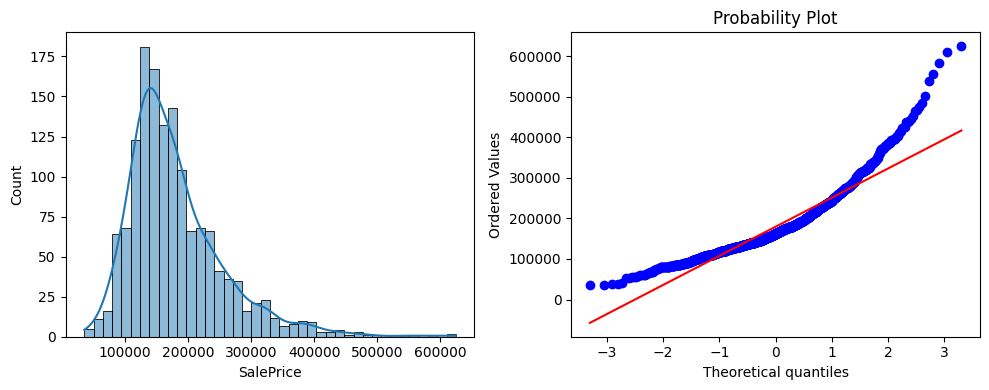

In [572]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sns.histplot(data=df, x='SalePrice', kde=True, ax=axes[0])
stats.probplot(df['SalePrice'], dist=stats.norm, plot=axes[1])

plt.tight_layout()

plt.show()

1. Analisando os gráficos acima, é possível observar que os valores de SalePrice não são normalmente distribuídos. Observa-se pelo gráfico à esquerda que há um alargamento da cauda para a direita, o que indica que existem imóveis sendo vendidos por um preço abaixo da média e que moda > mediana > média. O fato da curva ser "pontiaguda", pode ser um indicativo ve outliliers.

2. O gráfico QQ Plot faz a comparação da distribuição real (pontos em azul) com a distribuição teórica, que em nosso caso é a distribuição normal de probabilidade. Se os dados fossem normalmente distribuídos, a linha da distribuiçao teórica estaria ajustada a linha de distribuição teórica. 

In [573]:
stat, p_value = stats.shapiro(df.SalePrice)

print(f"Os dados não são normalmente distribuídos. p_value={p_value}")if p_value < 0.05  else print("Os dados estão normalmente distribuídos.")

Os dados não são normalmente distribuídos. p_value=2.533023742748385e-30


In [574]:
print("Skewness: ", df.SalePrice.skew())
print("Kurtosis: ", df.SalePrice.kurt())

Skewness:  1.534968247671716
Kurtosis:  3.7715669207625826


Outra forma de avaliar a normalidade de uma distribuição é utilizando os valores de <b>Skewness</b> e <b>Kurtosis</b>.
 
1. <b>Skewness.</b> Mede a assimetria dos dados em torno da média. Em uma distribuição normal, o valor do skewness é 0. Se o seu valor variar em torno de 0.5, podemos admitir que os dados são normalmente distribuídos. Por óbvio, valores de skewness positivos indicam uma cauda alondaga à direita, e valores negativos uma cauda alondaga à esqueda. 

2. <b>Kurtosis.</b> Avalia o quão "pontiaguda" é a distribuição quando comparada com a Normal, que possui Kurtosis igual a 3. Valores positivos e maiores que 3 sugerem a presença de outliers.

In [575]:
df['SalePrice_log1p'] = np.log1p(df['SalePrice'])
adicionar_features_criadas('SalePrice_log1p')

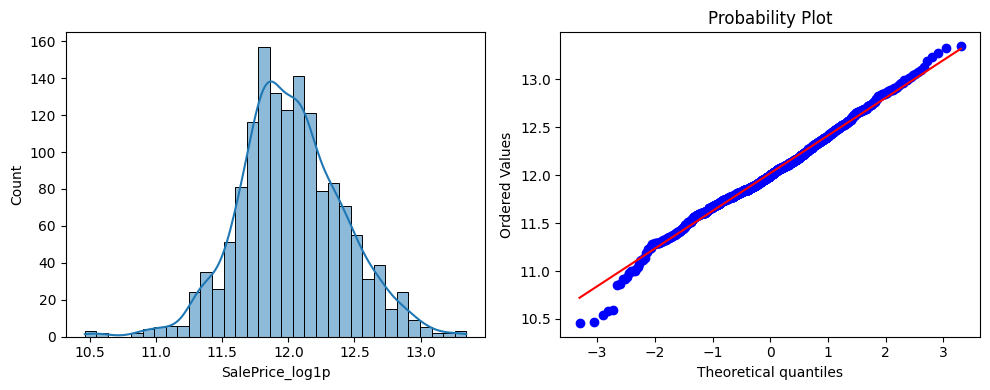

In [576]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.histplot(data=df, x='SalePrice_log1p', kde=True, ax=axes[0])
stats.probplot(df['SalePrice_log1p'], dist=stats.norm, plot=axes[1])
plt.tight_layout()
plt.show()

In [577]:
df[df.select_dtypes(include=['number']).columns].corr()[['SalePrice', 'SalePrice_log1p']].sort_values(by=['SalePrice_log1p'], ascending=False)[:20]

,SalePrice,SalePrice_log1p
SalePrice_log1p,0.9552,1.0000
SalePrice,1.0000,0.9552
index_qual_global,0.8197,0.8314
total_area_freq,0.8370,0.8204
total_area,0.8181,0.8168
OverallQual,0.7933,0.8157
perc_grlivarea_high_qual_log1p,0.7384,0.8015
perc_grlivarea_high_qual,0.7659,0.7520
GrLivArea_log1p,0.6996,0.7315
GrLivArea,0.7193,0.7171


##### GrLivArea

In [578]:
df['GrLivArea_log1p'] = np.log1p(df['GrLivArea'])

adicionar_caracteristicas_fortemente_correlacionadas('GrLivArea')
adicionar_features_criadas('GrLivArea_log1p')

Feature GrLivArea já existe


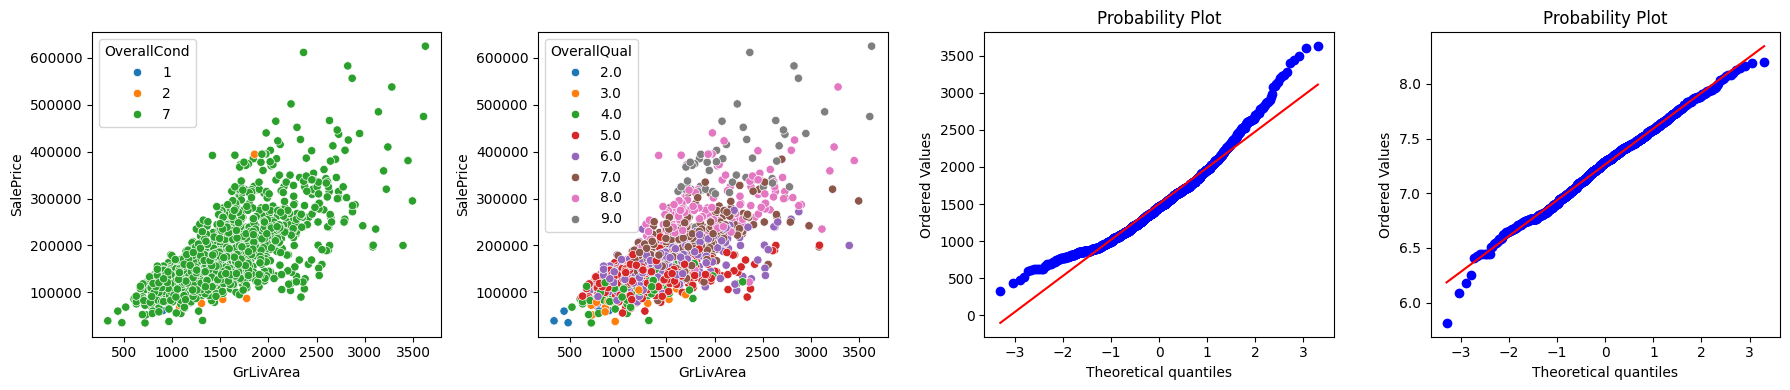

In [579]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))
sns.scatterplot(data=df, x='GrLivArea', y='SalePrice', hue='OverallCond', palette='tab10', ax=axes[0])
sns.scatterplot(data=df, x='GrLivArea', y='SalePrice', hue='OverallQual', palette='tab10', ax=axes[1])
stats.probplot(df['GrLivArea'], dist=stats.norm, plot=axes[2])
stats.probplot(df['GrLivArea_log1p'], dist=stats.norm, plot=axes[3])
plt.tight_layout()
plt.show()

1. Ao analisar os gráficos acima, é possível enxergar uma tendência de incremento de preço à medida que a área aumenta. Entretanto, há grande variabilidade no preço a partir dos valores de 2500 metros quadrados. Ao que parece, OverallCond os imóveis de maneira mais homogênea, mas também possui alta variabilidade de preço. Também há uma grande quantidade de imóvies com OverallCond igual a 5.

2. Quando olhamos a distribuição do preço x área x OverallQual, há uma maior variabilidade de preços nos imóveis de maior qualidade.  

3. Há um fato curioso. Os dois imóveis localizados à direita dos gráficos possuem OverallQual igual a 5 e OverallQual igual a 10. Como também há dois imóveis na parte superior do gráfico que possuem OveallCond de 5 e 6, OverallQuall igual a 10.

4. Os dados não estão normalmente distribuídos.

Removendo os outliers

In [580]:
outliers = df[df.GrLivArea > 4000]
df = df.drop(index=outliers.index)
df.iloc[outliers.index]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,Fence,MiscFeature,MiscVal,YrSold,SaleType,SaleCondition,SalePrice,GrLivArea_log1p,perc_grlivarea_high_qual,perc_grlivarea_high_qual_log1p,perc_bsmt_finish,total_area,index_qual_global,index_cond_global,age_house,age_remode,total_full_half_bathroom_ponderados,gr_liv_area_per_rooms_abgr,bedrooms_per_totalrooms,total_bath_rooms,diff_gr_liv_area_lot_area,lot_area_per_lot_frontage,total_area_freq,preco_metro_quadrado,foundation_count,SalePrice_log1p


O dicionário de dados informa que GrLivArea é a área total constuída "acima do solo". Pelo que entendi, GrLivArea é igual 1stFlrSF + 2ndFlrSF. Vamos checar isso.

In [581]:
temp = df.copy()
temp['soma_1s_2n'] = temp['1stFlrSF'] + temp['2ndFlrSF']
temp['diff_para_GrLivArea'] = temp['GrLivArea'] - temp['soma_1s_2n']
temp[['GrLivArea', 'soma_1s_2n', 'diff_para_GrLivArea', '1stFlrSF', '2ndFlrSF']].head(5)

KeyError: '1stFlrSF'

In [ ]:
temp[temp.diff_para_GrLivArea > 0][['GrLivArea', 'soma_1s_2n', 'diff_para_GrLivArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF']]

,GrLivArea,soma_1s_2n,diff_para_GrLivArea,1stFlrSF,2ndFlrSF,LowQualFinSF
51,1176,816,360,816,0,360
88,1526,1013,513,1013,0,513
125,754,520,234,520,0,234
170,1382,854,528,854,0,528
185,3608,3036,572,1518,1518,572
187,1656,1512,144,808,704,144
197,3112,2720,392,1360,1360,392
198,2229,1858,371,929,929,371
263,1316,926,390,926,0,390
267,2192,1772,420,1052,720,420


1. Existem 26 registros com aparente inconsistência. Após fazer testes, identifiquei que LowQualFinSF é a feature que faltava em nossa equação. Considerando que 1stFlrSF e 2ndFlrSF são equivalentes a GrLivArea, iremos removê-las para evitar problemas de multicolinearidade.

2. Iremos checar a correlação de LowQualFinSF com GrLivArea e SalePrice. Criaremos uma feature para será um índice de baixa qualidade para GrLivArea.

In [ ]:
df.drop(columns=['1stFlrSF', '2ndFlrSF'], inplace=True)

In [ ]:
df['perc_grlivarea_high_qual'] = (df.GrLivArea - df.LowQualFinSF / df.GrLivArea) * (df.OverallQual * df.OverallCond)

In [ ]:
df.drop(columns=['LowQualFinSF'], inplace=True)

Agora, iremos avaliar as features criadas avaliando as pontuações de correlação e importância.

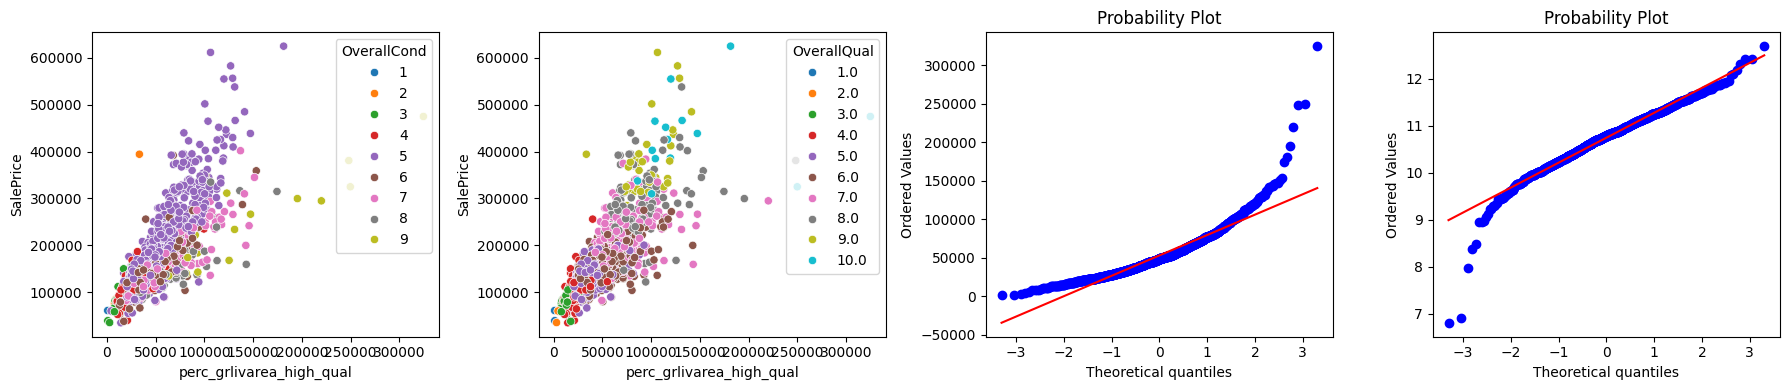

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))
sns.scatterplot(data=df, x='perc_grlivarea_high_qual', y='SalePrice', hue='OverallCond', palette='tab10', ax=axes[0])
sns.scatterplot(data=df, x='perc_grlivarea_high_qual', y='SalePrice', hue='OverallQual', palette='tab10', ax=axes[1])
stats.probplot(df['perc_grlivarea_high_qual'], dist=stats.norm, plot=axes[2])
stats.probplot(np.log(df['perc_grlivarea_high_qual']), dist=stats.norm, plot=axes[3])
plt.tight_layout()
plt.show()

Aplicando a transformação logaritimica sobre a feature recém criada e avaliando a importância das features e seu desempenho em validação cruzada.

In [ ]:
df['perc_grlivarea_high_qual_log1p'] = np.log(df['perc_grlivarea_high_qual'])
adicionar_caracteristicas_fortemente_correlacionadas('perc_grlivarea_high_qual')
adicionar_features_criadas('perc_grlivarea_high_qual_log1p')

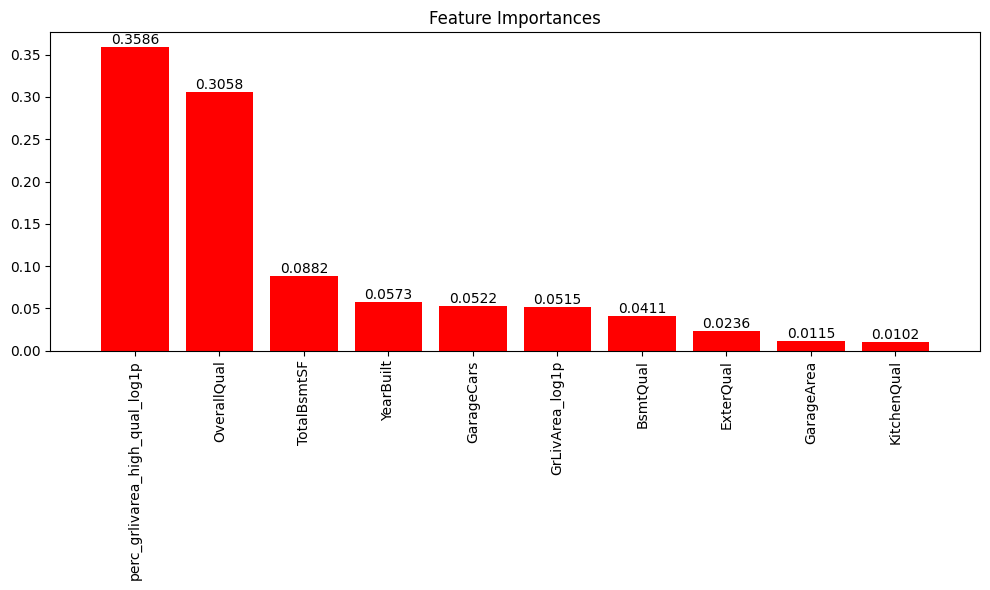

In [ ]:
best_features = get_best_features_dataframe(df[df.select_dtypes(include=['number']).columns], df['SalePrice'], top=10, remover_colunas_altamente_correlacionadas=True)
set_feature_importance(df[df[best_features.index].columns], df['SalePrice'], num_features=10)

In [ ]:
best_features

,MIScore,Pearson,Spearman
perc_grlivarea_high_qual_log1p,0.6254,0.7381,0.8062
OverallQual,0.5742,0.8009,0.8103
GrLivArea_log1p,0.4924,0.7000,0.7312
YearBuilt,0.3705,0.5353,0.6534
GarageArea,0.3667,0.6370,0.6490
TotalBsmtSF,0.3649,0.6466,0.6020
GarageCars,0.3594,0.6493,0.6897
KitchenQual,0.3357,0.6662,0.6724
BsmtQual,0.3350,0.5921,0.6776
ExterQual,0.3247,0.6946,0.6841


In [ ]:
# d = avaliar_modelos_em_validacao_cruzada(X=df[feature_importance_cols], y=df['SalePrice'])

################################  STATS ########################################

                          models  score    std  r2_score
2      GradientBoostingRegressor 0.1420 0.0126    0.8757
0          RandomForestRegressor 0.1431 0.0161    0.8703
4                  LGBMRegressor 0.1451 0.0154    0.8674
6  HistGradientBoostingRegressor 0.1465 0.0146    0.8702
7               BaggingRegressor 0.1475 0.0175    0.8656
1            ExtraTreesRegressor 0.1479 0.0163    0.8692
5                   XGBRegressor 0.1533 0.0181    0.8459
3              AdaBoostRegressor 0.1902 0.0235    0.8239

A variável perc_grlivarea_high_qual_log1p níveis altos de correlação e importância para a variável SalePrice. Iremos adicionar esse passo a passo em um método que será chamado pelo obter_dataframe_processado.

##### TotalBsmtSF

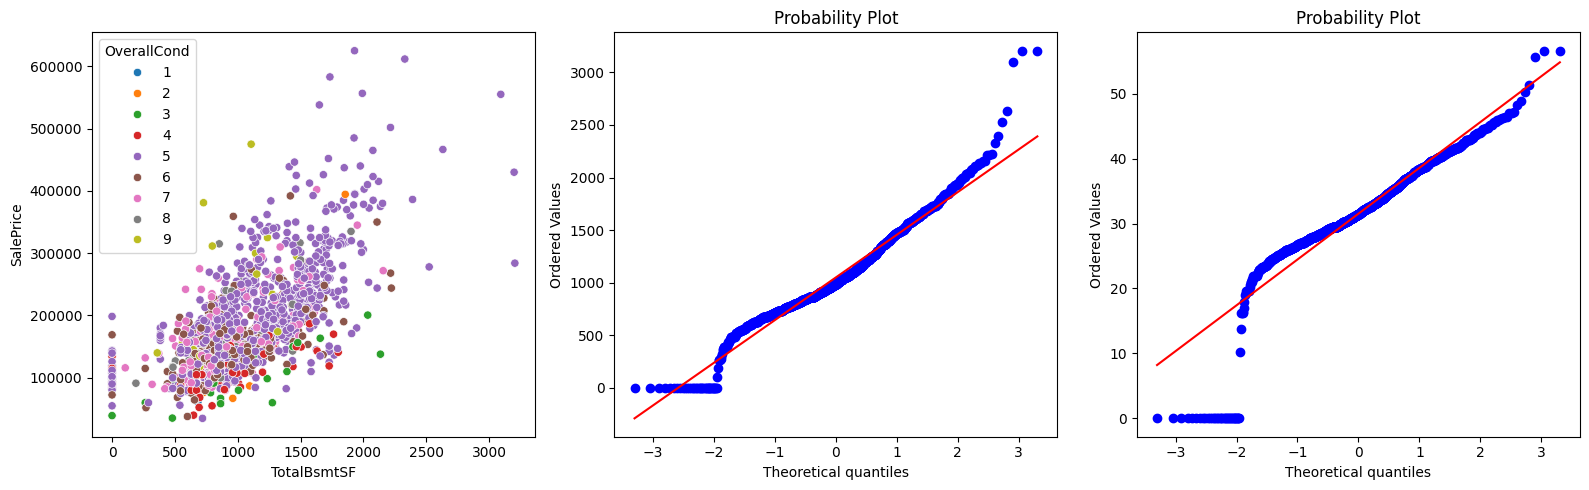

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
sns.scatterplot(data=df, x='TotalBsmtSF', y='SalePrice', hue='OverallCond', palette='tab10', ax=axes[0])
stats.probplot(df['TotalBsmtSF'], dist=stats.norm, plot=axes[1])
stats.probplot(np.sqrt(df['TotalBsmtSF']), dist=stats.norm, plot=axes[2])
plt.tight_layout()
plt.show()

1. Os gráficos acima nos mostram que a a distribuição dos dados do basement são bem peculiares. Isso porque há uma quantidade de imóveis que não possuem basement, o que é indicado em todos os gráficos. Apliquei uma transformação de raíz quadrada para tentar aproximar a curva da distribuição teórica e manter a os zeros (0) para indicar que não existe basement.

2. Uma transformação de raiz quadrada não pareceu promissora.

3. Há grande variabilidade de área e preço para OverallCond igual a 5. 

4. Iremos remover os outliers localizados à direita do gráfico, valores de TotalBsmtSF > 3000.

In [ ]:
outliers = df[df['TotalBsmtSF'] > 3000]
outliers

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,Fence,MiscFeature,MiscVal,YrSold,SaleType,SaleCondition,SalePrice,SalePrice_log1p,GrLivArea_log1p,perc_grlivarea_high_qual,perc_grlivarea_high_qual_log1p
332,333,20,RL,85.0000,10655,0,3,4,1,3,NridgHt,Norm,Norm,1Fam,1Story,8.0000,5,2003,2004,Gable,CompShg,VinylSd,VinylSd,BrkFace,296.0000,4,3,PConc,4,3,1,GLQ,1124.0000,Unf,479.0000,1603.0000,3206.0000,GasA,5,1,5,1629,1.0000,0.0000,2,0,3,1,4,7,8,1,Attchd,2003.0000,2,3.0000,880.0000,3,3,3,0,0,0,0,NA,NA,0,2009,WD,Normal,284000.0000,12.5567,7.3963,65160.0000,11.0846
440,441,20,RL,105.0000,15431,0,4,4,1,3,NridgHt,Norm,Norm,1Fam,1Story,10.0000,5,2008,2008,Hip,CompShg,VinylSd,VinylSd,Stone,200.0000,5,3,PConc,5,3,4,GLQ,1767.0000,ALQ,539.0000,788.0000,3094.0000,GasA,5,1,5,2402,1.0000,0.0000,2,0,2,1,5,10,8,2,Attchd,2008.0000,3,3.0000,672.0000,3,3,3,0,72,0,170,NA,NA,0,2009,WD,Normal,555000.0000,13.2267,7.7845,120100.0000,11.6961
496,497,20,RL,68.9862,12692,0,3,4,1,3,NoRidge,Norm,Norm,1Fam,1Story,8.0000,5,1992,1993,Hip,CompShg,BrkFace,BrkFace,None,0.0000,4,3,PConc,4,3,1,GLQ,1231.0000,Unf,0.0000,1969.0000,3200.0000,GasA,5,1,5,3228,1.0000,0.0000,3,0,4,1,4,10,8,1,Attchd,1992.0000,2,2.0000,546.0000,3,3,3,264,75,291,0,NA,NA,0,2007,WD,Normal,430000.0000,12.9715,8.0799,129120.0000,11.7685


In [ ]:
df.drop(index=outliers.index, inplace=True)

Agora, vamos dar uma olhada nos atributos de área relacionados a TotalBsmtSF, seguindo a mesma abordagem de GrLivArea.

In [ ]:
temp = df.copy()
temp[['BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2']]= temp[['BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2']].fillna(0)

temp['soma_SF1_SF2'] = temp['BsmtFinSF1'] + temp['BsmtFinSF2']
temp['diff'] = temp['TotalBsmtSF'] - temp['soma_SF1_SF2']

temp[['BsmtFinSF1', 'BsmtFinSF2', 'soma_SF1_SF2', 'TotalBsmtSF', 'diff', 'BsmtUnfSF']].head(5)

,BsmtFinSF1,BsmtFinSF2,soma_SF1_SF2,TotalBsmtSF,diff,BsmtUnfSF
0,706.0000,0.0000,706.0000,856.0000,150.0000,150.0000
1,978.0000,0.0000,978.0000,1262.0000,284.0000,284.0000
2,486.0000,0.0000,486.0000,920.0000,434.0000,434.0000
3,216.0000,0.0000,216.0000,756.0000,540.0000,540.0000
4,655.0000,0.0000,655.0000,1145.0000,490.0000,490.0000


In [ ]:
temp[temp['diff'] != temp['BsmtUnfSF']]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,Fence,MiscFeature,MiscVal,YrSold,SaleType,SaleCondition,SalePrice,SalePrice_log1p,GrLivArea_log1p,perc_grlivarea_high_qual,perc_grlivarea_high_qual_log1p,soma_SF1_SF2,diff


A exemplo do que ocorreu com GrLivArea, iremos criar novas features. Mas antes, vamos dar uma olhada no heatmap das features relaionadas aos basements e obter alguns insigths de novas features.

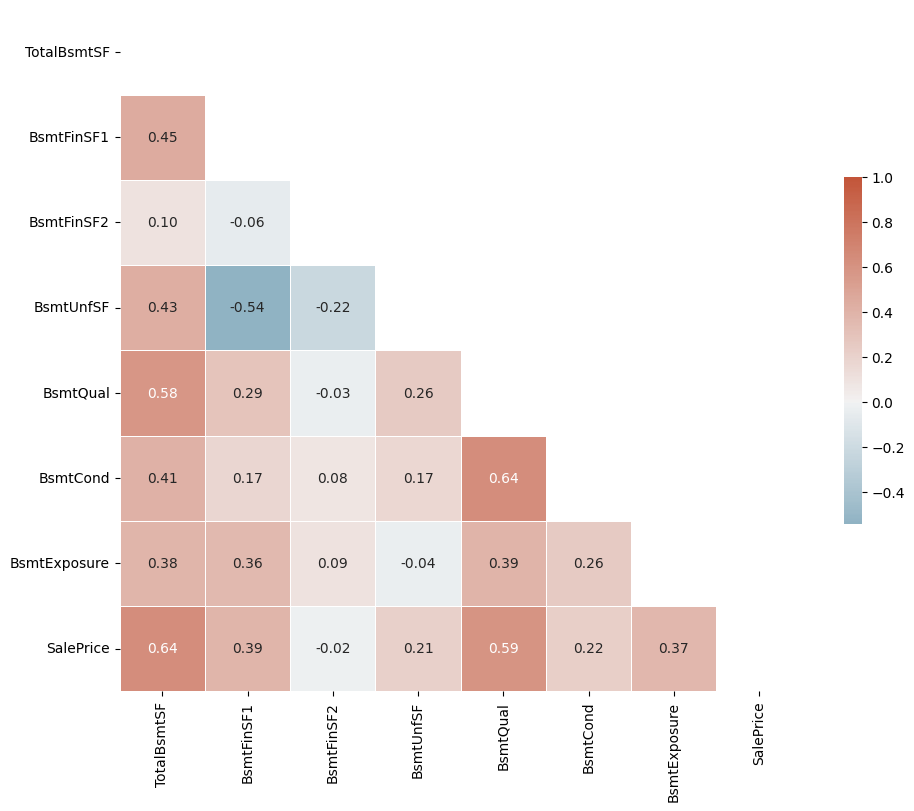

In [ ]:
corr = df[['TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtQual', 'BsmtCond', 'BsmtExposure',  'SalePrice']].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap, 
            vmax=1, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5},
            annot=True, 
            fmt=".2f")
plt.show()

1. Há correlação moderada entre BsmtQual (altura) e BsmtCond (estado de conservação). Iremos testar a combinação de ambas para e analisar os resultados.
2. Há uma correlação quaser forte entre BsmtFinSF2 e BsmtFinType1 e 2. Iremos avaliar a remoção de uma ou ambas.
3. Ao analisar as descrições das features BsmtFinType1 e BsmtFinType2, percebi que elas parecem ser complementares. Além disso, esssas features parecem avaliar aspectos diferentes de um basement. No início de do projeto, optei por codificá-las em uma variável categórica com gradação de qualidade. Porém, após essa análise mais aprofundada, acredito que One Hot Encoding seja a melhor forma de codificá-las.

In [ ]:
def calc_perc_bsmt_finish(row: pd.Series):
    finished = row.TotalBsmtSF - row.BsmtUnfSF
    perc = np.nan_to_num(finished/row.TotalBsmtSF) * np.exp2((row.BsmtQual  + row.BsmtCond))
    return perc 

In [ ]:
df['perc_bsmt_finish'] = df[['TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtQual', 'BsmtCond', 'BsmtExposure']].apply(calc_perc_bsmt_finish, axis=1)
adicionar_features_criadas('perc_bsmt_finish')

df['total_area'] = df['GrLivArea'] + df['TotalBsmtSF']
adicionar_features_criadas('total_area')

adicionar_caracteristicas_fortemente_correlacionadas('BsmtFinSF1')
adicionar_caracteristicas_fortemente_correlacionadas('BsmtFinSF2')

# adicionar_caracteristicas_fortemente_correlacionadas('BsmtCond')
# adicionar_caracteristicas_fortemente_correlacionadas('BsmtQual')

adicionar_features_criadas('total_area')
adicionar_features_criadas('perc_bsmt_finish')

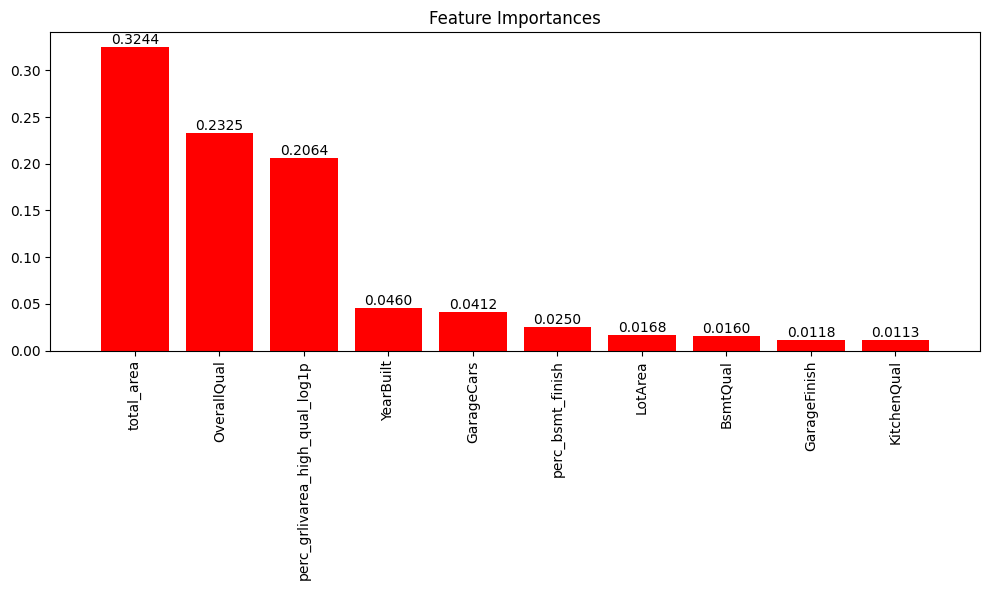

,MIScore,Pearson,Spearman
total_area,0.6584,0.8181,0.8144
perc_grlivarea_high_qual_log1p,0.6200,0.7384,0.8054
OverallQual,0.5544,0.8002,0.8092
GrLivArea_log1p,0.4904,0.6996,0.7303
GarageCars,0.3695,0.6509,0.6888
YearBuilt,0.3661,0.5360,0.6524
TotalBsmtSF,0.3660,0.6388,0.5996
GarageArea,0.3638,0.6403,0.6480
ExterQual,0.3282,0.6929,0.6825
KitchenQual,0.3250,0.6660,0.6712


In [ ]:
best_features = get_best_features_dataframe(df[df.select_dtypes(include=['number']).columns], df['SalePrice'], remover_colunas_altamente_correlacionadas=True)
set_feature_importance(df[df[best_features.index].columns], df['SalePrice'], num_features=10)
best_features.sort_values(by='MIScore', ascending=False).head(10)

In [ ]:
# d = avaliar_modelos_em_validacao_cruzada(X=df[feature_importance_cols], y=df['SalePrice'])

################################  STATS ########################################

                          models  score    std  r2_score
2      GradientBoostingRegressor 0.1279 0.0136    0.9049
6  HistGradientBoostingRegressor 0.1322 0.0138    0.8957
0          RandomForestRegressor 0.1327 0.0141    0.8925
4                  LGBMRegressor 0.1329 0.0132    0.8974
7               BaggingRegressor 0.1356 0.0139    0.8862
1            ExtraTreesRegressor 0.1358 0.0132    0.8894
5                   XGBRegressor 0.1389 0.0114    0.8755
3              AdaBoostRegressor 0.1778 0.0213    0.8424

##### Qualidade

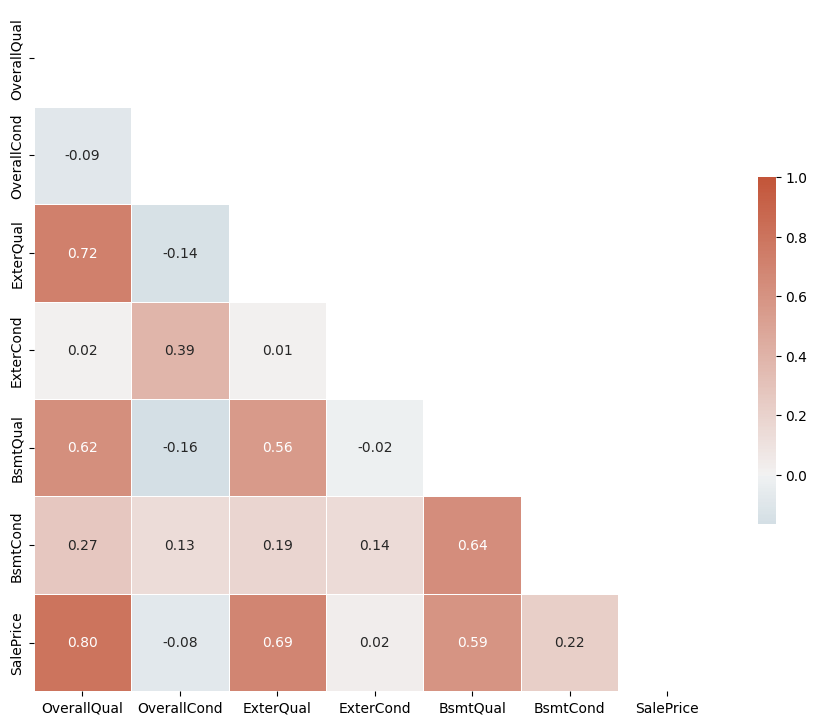

In [ ]:
plot_heatmap(df[['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'SalePrice']].corr())

1. Dando uma olhada no heatmap de todos os atributos relacionados à qualidade e condições, podemos perceber que OverallQual e ExterQual possuem entre si uma correlação moderada e com SalePrice. 
2. O mesmop fato se aplica a BsmtQual e BsmtCond, que possuem correlação moderada entre si e com SalePrice. 
3. OverallQual e OverallCond não possuem correlação levemente negativa. 

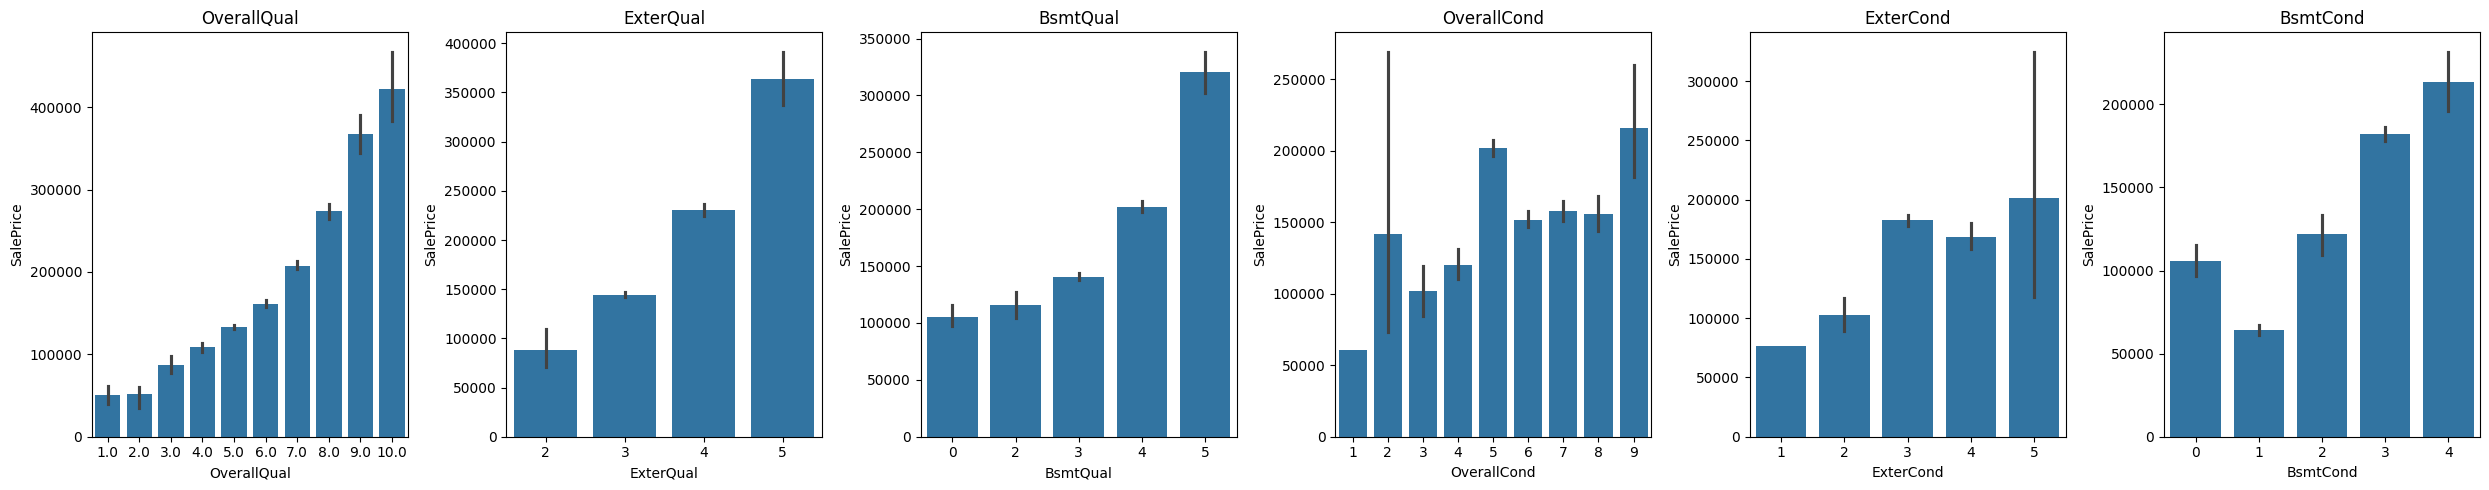

In [ ]:
features = ['OverallQual', 'ExterQual', 'BsmtQual', 'OverallCond', 'ExterCond', 'BsmtCond']
fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(25, 5))

for index, feature in enumerate(features):
    sns.barplot(data=df, x=feature, y='SalePrice', ax=axes[index]) 
    axes[index].set_title(feature) 

plt.tight_layout()
plt.show()


A partir da análise dos gráficos acima, podemos perceber que:
1. claramente que há uma tendência de aumento de preço à medida que a qualidade aumenta ('OverallQual', 'OverallCond', 'ExterQual')
2. Embora as condições do imóvel influenciem o preço, não há uma relação clara de que melhores condições conduzam à preços maiores. 

Iremos fazer alguns ajustes nas categorias para ver se sua correlação e importância melhoram.

In [ ]:
df['OverallQual'] = df['OverallQual'].replace({1: 2, 10: 9})
df['BsmtQual'] = df['BsmtQual'].replace({0: 2})
df['BsmtCond'] = df['BsmtCond'].replace({0: 1})
df['OverallCond'] = df['OverallCond'].replace({9: 7, 8: 7, 6: 7, 5: 7, 4: 7, 3: 7})
df['ExterCond'] = df['ExterCond'].replace({5: 4, 3: 4})

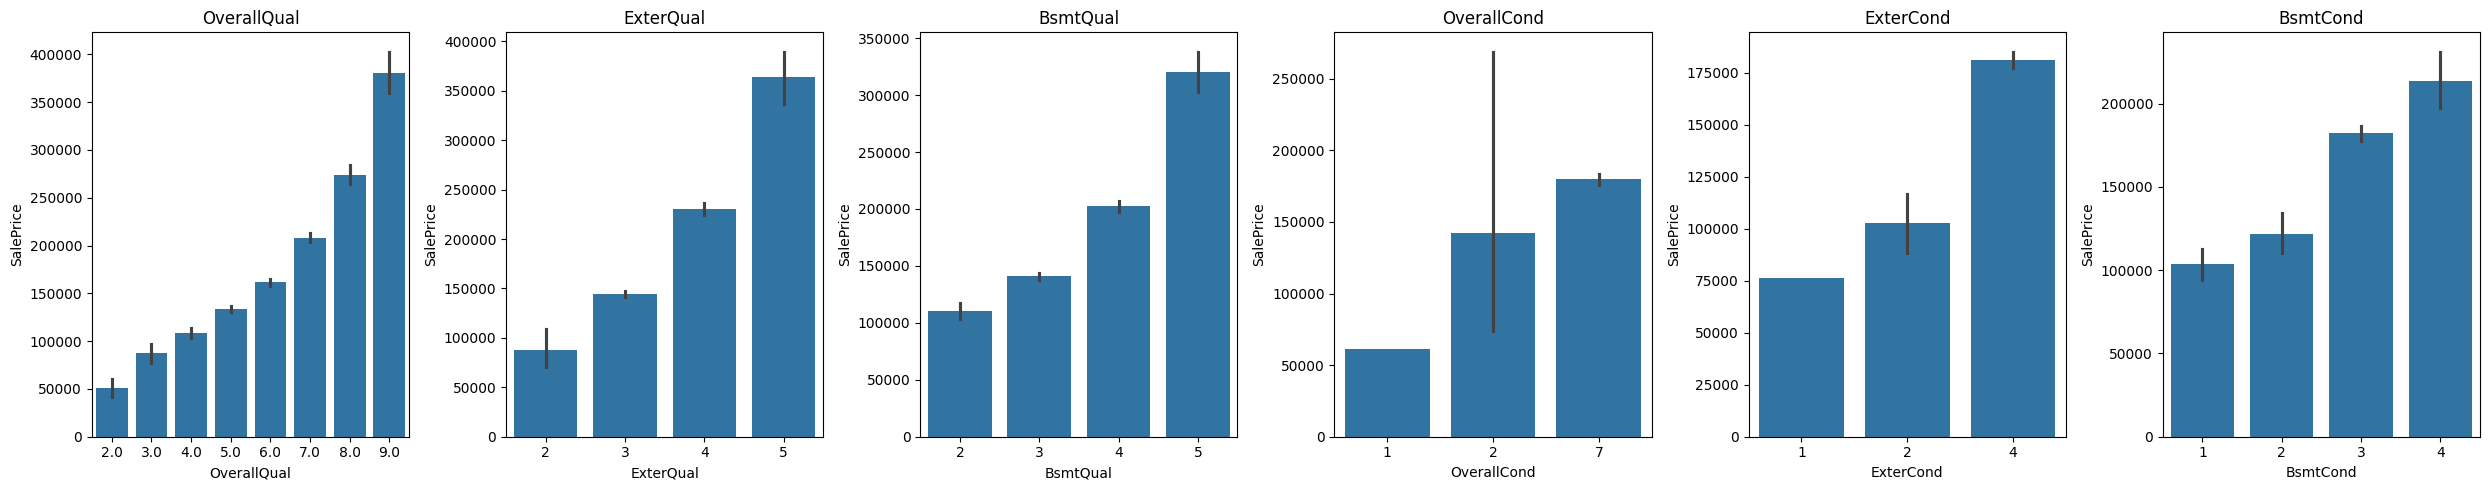

In [ ]:
features = ['OverallQual', 'ExterQual', 'BsmtQual', 'OverallCond', 'ExterCond', 'BsmtCond']
fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(25, 5))

for index, feature in enumerate(features):
    sns.barplot(data=df, x=feature, y='SalePrice', ax=axes[index]) 
    axes[index].set_title(feature) 

plt.tight_layout()
plt.show()

In [ ]:
df['index_qual_global'] = df.OverallQual + df.ExterQual + df.BsmtQual
df['index_cond_global'] = df.OverallCond + df.ExterCond + df.BsmtCond

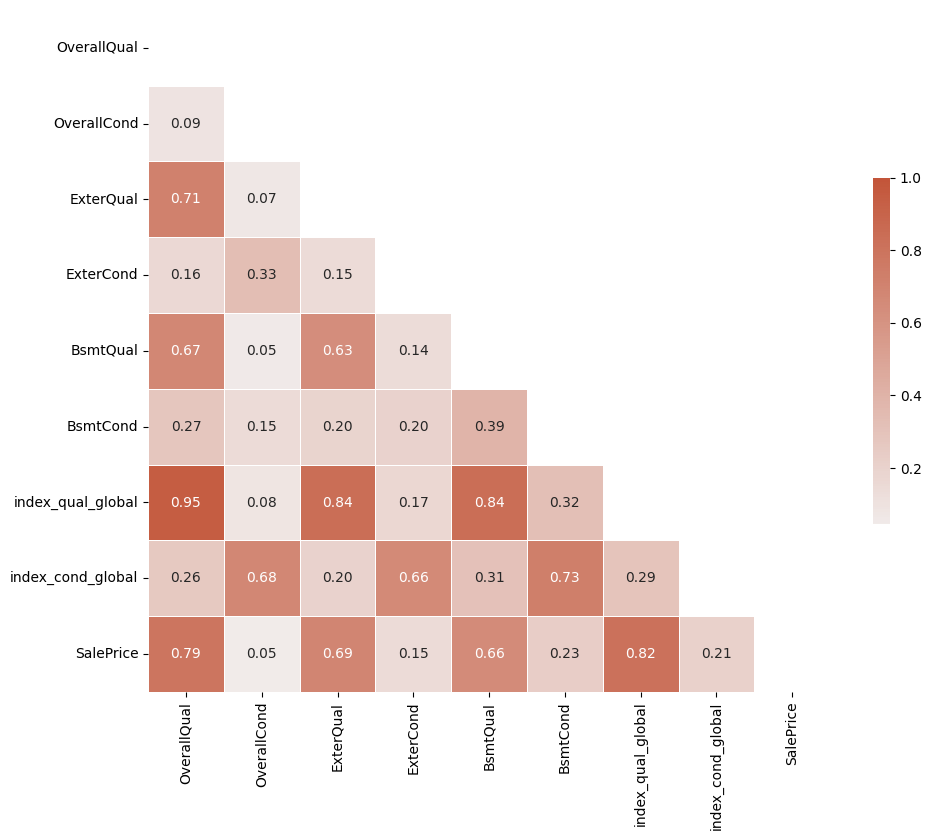

In [ ]:
plot_heatmap(df[['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'index_qual_global', 'index_cond_global', 'SalePrice']].corr())

In [ ]:
adicionar_features_criadas('index_qual_global')
adicionar_caracteristicas_fortemente_correlacionadas('OverallQual')
adicionar_caracteristicas_fortemente_correlacionadas('ExterQual')
adicionar_caracteristicas_fortemente_correlacionadas('BsmtQual')

adicionar_caracteristicas_fortemente_correlacionadas('OverallCond')
adicionar_caracteristicas_fortemente_correlacionadas('ExterCond')
adicionar_caracteristicas_fortemente_correlacionadas('BsmtCond')

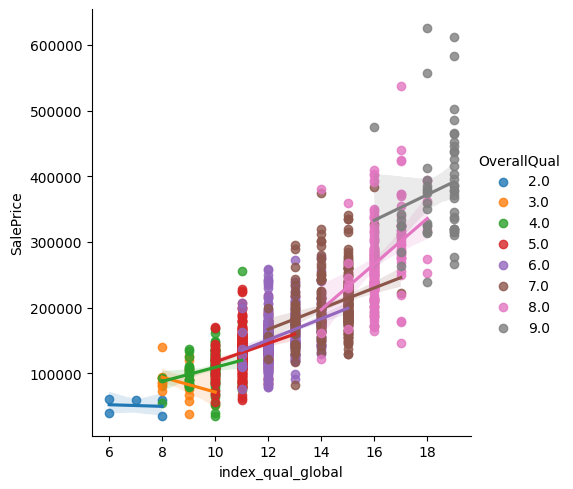

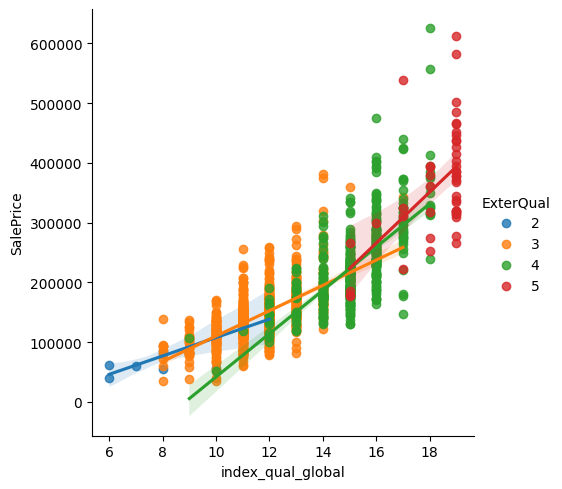

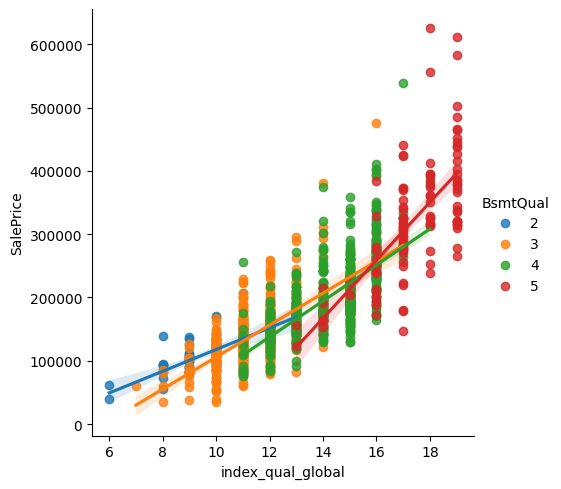

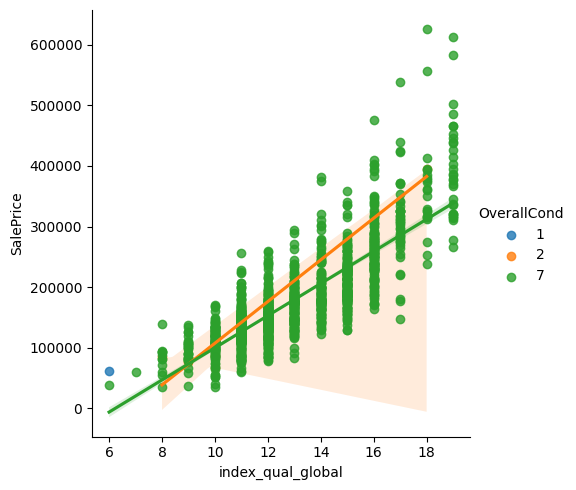

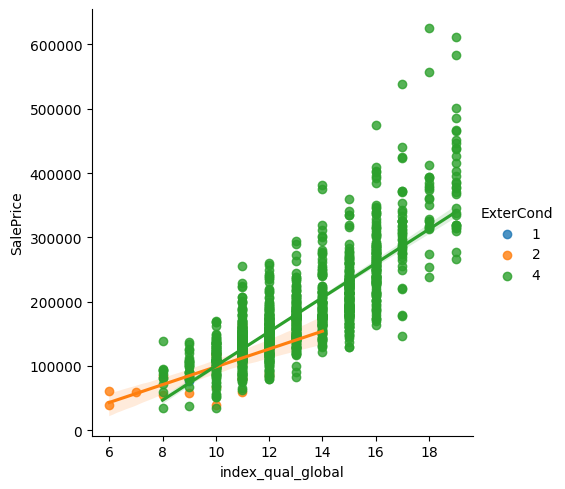

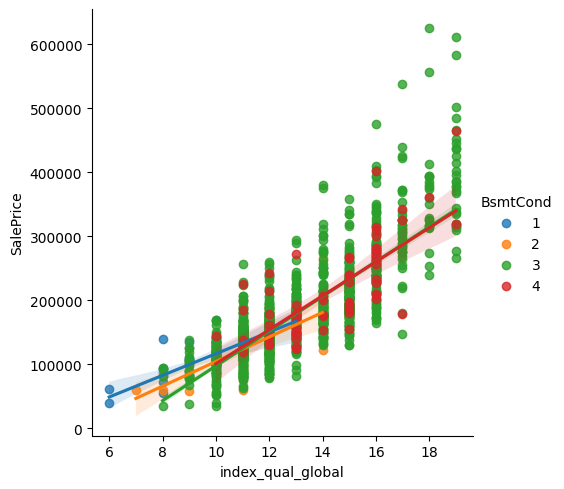

In [ ]:
for feature in features:
    sns.lmplot(data=df, x='index_qual_global', y='SalePrice', hue=feature)

Após realizarmos alguns ajustes nas features categóricas de qualidade, os preços tendem a aumentar com o incremento da qualidade ou condição. O indicador de qualidade apresenta uma reta de regressão bem ajustada aos indicadores de qualidade. Agora vamos dar uma olhada nos números dessa nova feature.

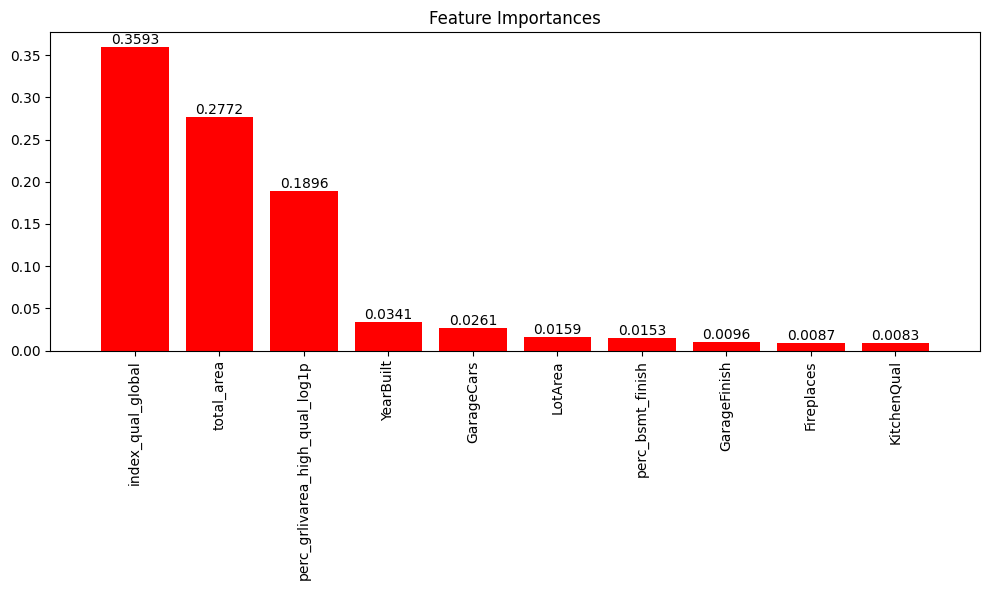

                                MIScore  Pearson  Spearman
total_area                       0.6591   0.8181    0.8144
index_qual_global                0.6232   0.8197    0.8313
perc_grlivarea_high_qual_log1p   0.6175   0.7384    0.8054
GrLivArea_log1p                  0.4903   0.6996    0.7303
GarageCars                       0.3688   0.6509    0.6888
GarageArea                       0.3687   0.6403    0.6480
TotalBsmtSF                      0.3628   0.6388    0.5996
YearBuilt                        0.3595   0.5360    0.6524
KitchenQual                      0.3315   0.6660    0.6712
GarageYrBlt                      0.3098   0.5324    0.6340


In [ ]:
plot_stats_features(df=df, num_features=10, remover_colunas_altamente_correlacionadas=True)

In [ ]:
# d = avaliar_modelos_em_validacao_cruzada(X=df[feature_importance_cols], y=df['SalePrice'])

################################  STATS ########################################

                          models  score    std  r2_score
2      GradientBoostingRegressor 0.1269 0.0129    0.9054
6  HistGradientBoostingRegressor 0.1300 0.0125    0.8974
0          RandomForestRegressor 0.1305 0.0152    0.8991
1            ExtraTreesRegressor 0.1311 0.0142    0.8954
4                  LGBMRegressor 0.1315 0.0134    0.9008
7               BaggingRegressor 0.1338 0.0149    0.8947
5                   XGBRegressor 0.1365 0.0100    0.8862
3              AdaBoostRegressor 0.1793 0.0221    0.8486

##### YearBuilt, YrSold, YearRemodAdd

<Axes: xlabel='YrSold', ylabel='count'>

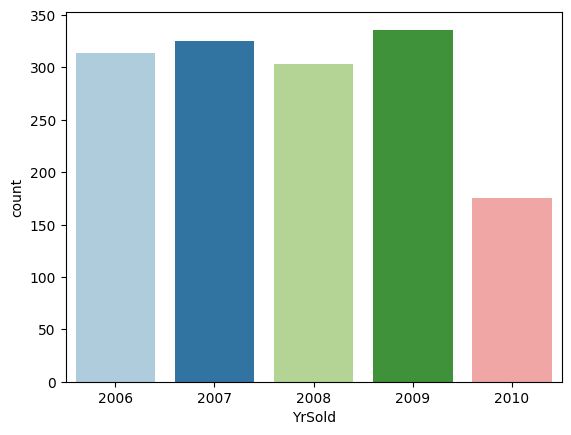

In [ ]:
sns.barplot(df.YrSold.value_counts(), palette=palete)

<Axes: xlabel='YearBuilt', ylabel='SalePrice'>

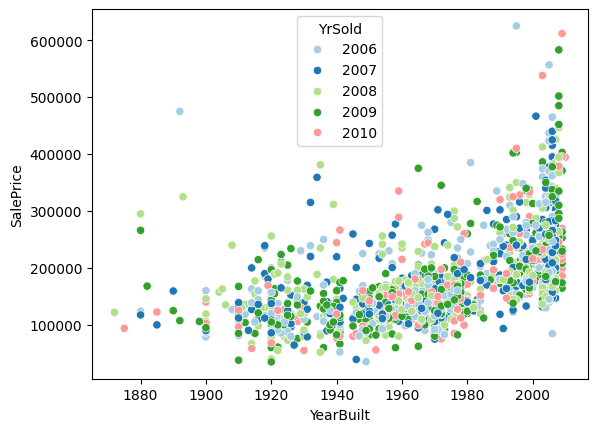

In [ ]:
sns.scatterplot(data=df, x='YearBuilt', y='SalePrice', hue='YrSold', palette=palete)

<Axes: xlabel='YrSold', ylabel='SalePrice'>

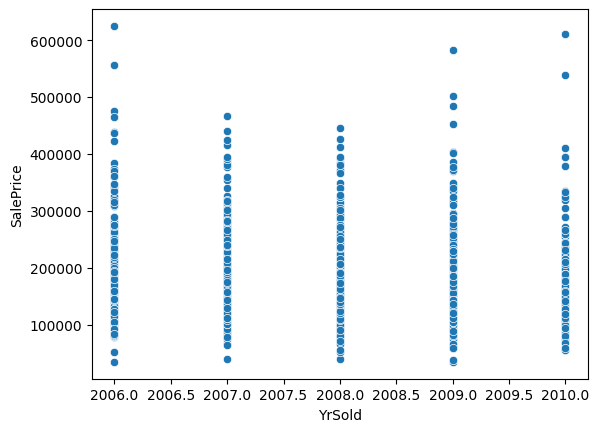

In [ ]:
sns.scatterplot(data=df, x='YrSold', y='SalePrice', palette=palete)

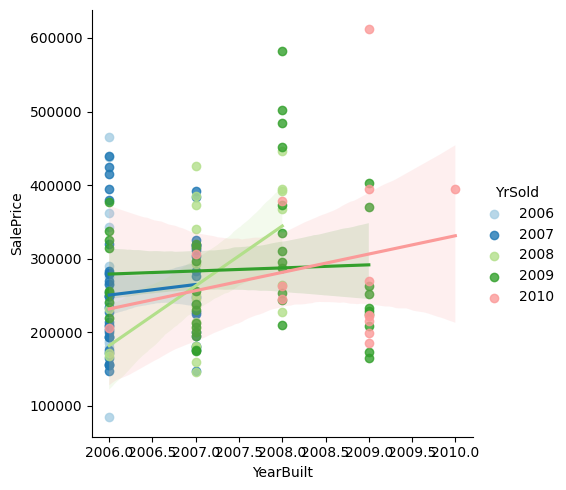

In [ ]:
sns.lmplot(data=df[ (df['YearBuilt'] >= 2006) ], x='YearBuilt', y='SalePrice', hue='YrSold', palette=palete)

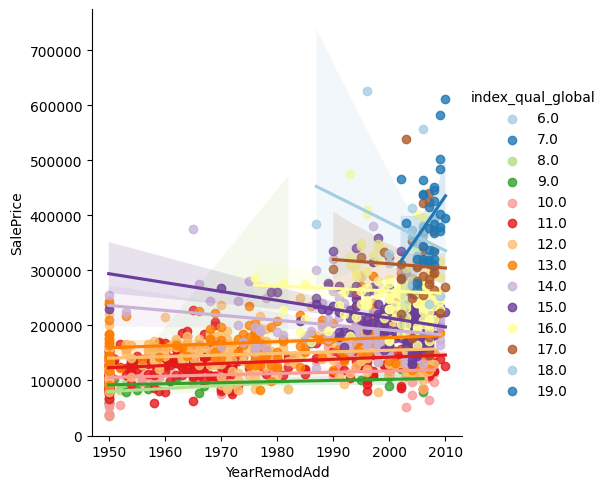

In [ ]:
sns.lmplot(data=df, x='YearRemodAdd', y='SalePrice', palette=palete, hue='index_qual_global')

1. Nâo parece haver uma tendência bem delineada entre YearBuilt e YrSold e YearRemodAdd, até mesmo filtrando os imóveis mais novos. Com muita "boa vontade", conseguimos visualizar uma reta ou curva exponencial suave no gráfico YearBuilt X SalePrice. 

2. Tentaremos melhorar a interpretabilidade dessas features criando atributos categóricos utilizando clusters e o método o "gráfico de cotovelo" para selecionar a melhor quantidade de clusters.

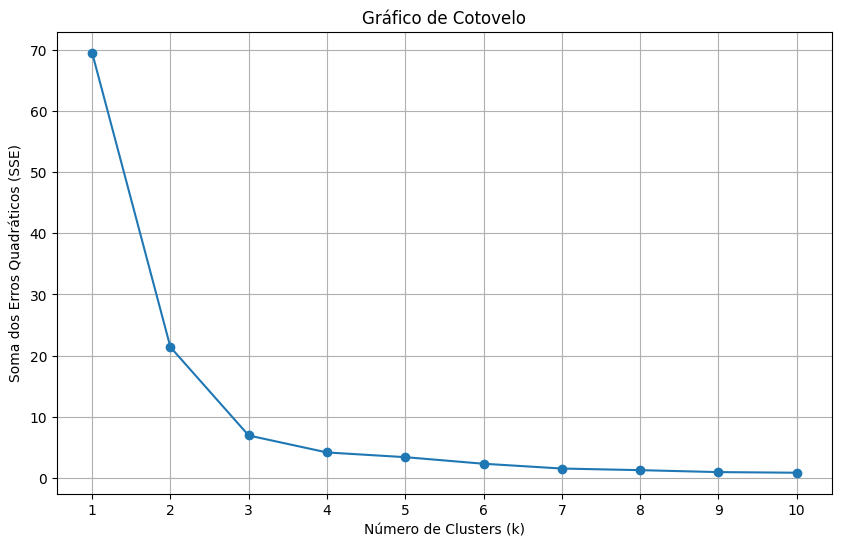

In [ ]:
plot_elbow(data=df[['YearBuilt']], max_clusters=10)

In [ ]:
temp_cluster01 = df.copy()

temp_cluster01['cluster_year_built'] = KMeans(n_clusters=2, max_iter=10000, n_init=1000).fit_predict(temp_cluster01[['YearBuilt']])

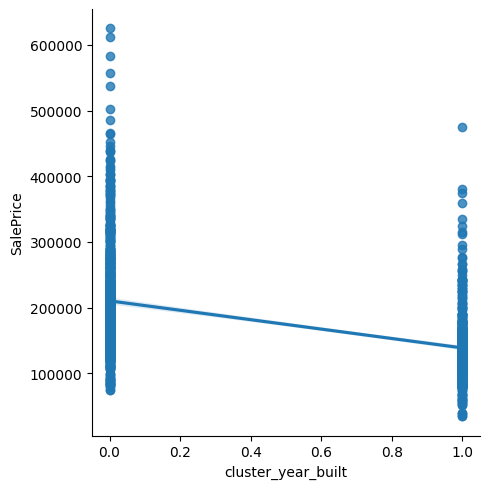

In [ ]:
sns.lmplot(temp_cluster01, x='cluster_year_built', y='SalePrice')

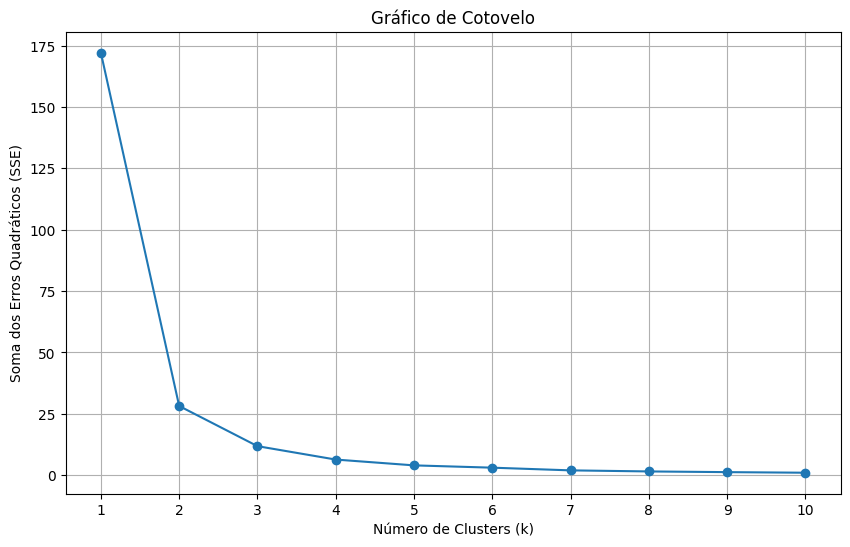

In [ ]:
plot_elbow(data=df[['YearRemodAdd']], max_clusters=10)

In [ ]:
temp_cluster01['cluster_year_remod'] = KMeans(n_clusters=2, max_iter=10000, n_init=1000).fit_predict(temp_cluster01[['YearBuilt']])

In [ ]:
get_best_features_dataframe(X=temp_cluster01[['cluster_year_remod', 'YearRemodAdd', 'cluster_year_built', 'YearBuilt']], y=df['SalePrice'])

,MIScore,Pearson,Spearman
YearBuilt,0.3649,0.5360,0.6524
YearRemodAdd,0.2437,0.5229,0.5722
cluster_year_built,0.1745,-0.4675,-0.5468
cluster_year_remod,0.1743,-0.4675,-0.5468


1. O uso de clusters não melhorou a pontuação das variáveis YearBuilt e YearRemodAdd. Por essa razão, não serão utilizadas.
2. Criaremos atributos para a idade do imóvel e idade da reforma.

In [ ]:
df['age_house'] = df[['YrSold', 'YearBuilt']].apply(lambda x: x[0] - x[1] if x[0] != x[1] else 0.1, axis=1)
df['age_remode'] = df[['YrSold', 'YearRemodAdd', 'age_house']].apply(lambda x: x[0] - x[1] if (x[0] != x[1] and x[1] > 0) else x[2], axis=1)

get_best_features_dataframe(X=df[['age_house', 'YearRemodAdd', 'age_remode', 'YearBuilt']], y=df['SalePrice'])

,MIScore,Pearson,Spearman
YearBuilt,0.3649,0.5360,0.6524
age_house,0.3397,-0.5362,-0.6500
age_remode,0.2628,-0.5282,-0.5857
YearRemodAdd,0.2437,0.5229,0.5722


As features de idade tem pontuações equivalentes às features relacionadas com correlações negativas, o que dá a entender que o quanto maior for a idade, menor o preço.

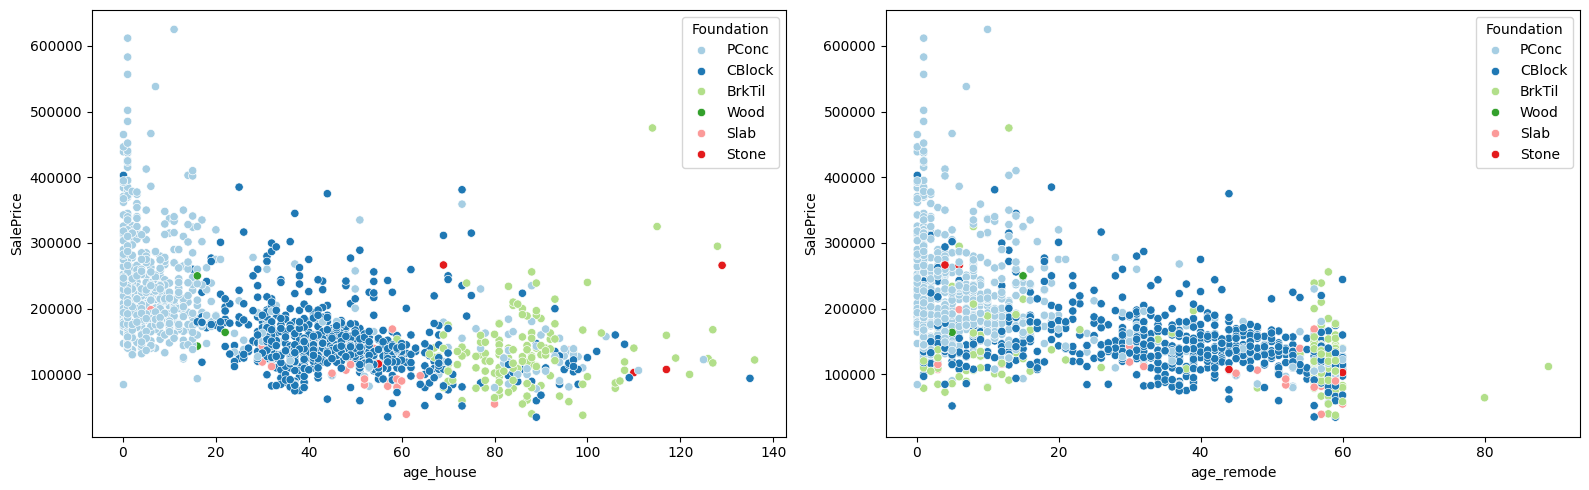

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
sns.scatterplot(data=df, x='age_house', y='SalePrice', hue='Foundation', palette=palete, ax=axes[0])
sns.scatterplot(data=df, x='age_remode', y='SalePrice', hue='Foundation', palette=palete, ax=axes[1])
plt.tight_layout()
plt.show()

Interessante! A idade das casas guarda relação com o tipo de material utilizado, mas ainda não sei o que fazer com essa informação rsrsrs. Até o momento, nennhuma variável foi processada via One Hot Encoding. Meu palpite é que Foundation irá melhorar a performance do modelo.

In [ ]:
df['index_qual_area'] = (np.sqrt(df['total_area']) / df['age_house']) * df['OverallQual']
df['index_qual_area_remod'] = (np.sqrt(df['total_area']) / df['age_remode']) * df['OverallQual']

adicionar_caracteristicas_fortemente_correlacionadas('age_house')
adicionar_caracteristicas_fortemente_correlacionadas('age_remode')

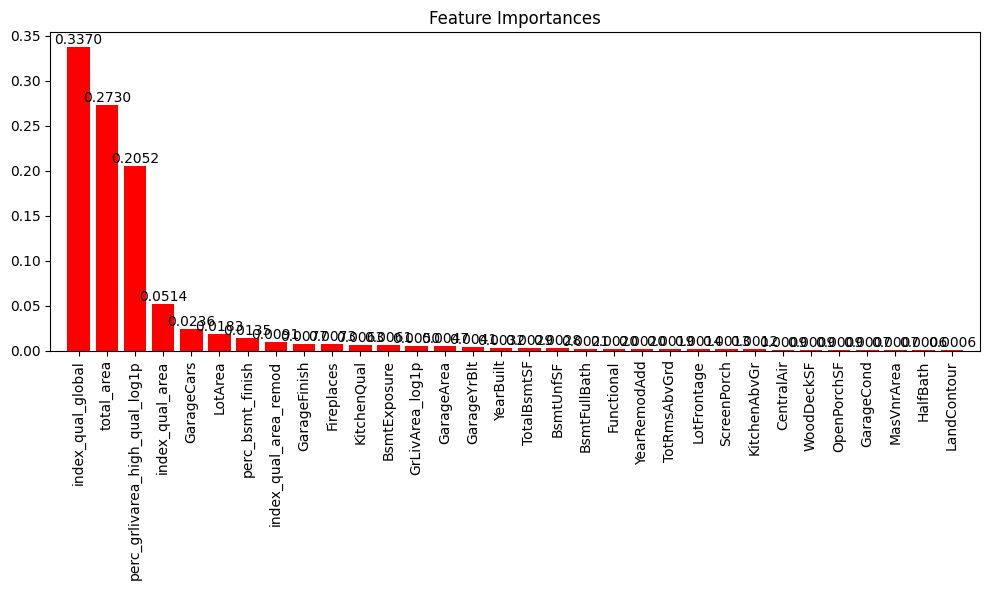

                                MIScore  Pearson  Spearman
total_area                       0.6552   0.8181    0.8144
index_qual_global                0.6215   0.8197    0.8313
perc_grlivarea_high_qual_log1p   0.6178   0.7384    0.8054
GrLivArea_log1p                  0.4888   0.6996    0.7303
index_qual_area                  0.4702   0.3445    0.7699
index_qual_area_remod            0.3999   0.3504    0.6967
YearBuilt                        0.3660   0.5360    0.6524
TotalBsmtSF                      0.3635   0.6388    0.5996
GarageArea                       0.3633   0.6403    0.6480
GarageCars                       0.3593   0.6509    0.6888
KitchenQual                      0.3243   0.6660    0.6712
GarageYrBlt                      0.3052   0.5324    0.6340
MSSubClass                       0.2743  -0.0836    0.0096
FullBath                         0.2579   0.5583    0.6334
GarageFinish                     0.2578   0.5584    0.6332
YearRemodAdd                     0.2520   0.5229    0.57

In [ ]:
plot_stats_features(df=df, num_features=32, remover_colunas_altamente_correlacionadas=True)

In [ ]:
# d = avaliar_modelos_em_validacao_cruzada(X=df[feature_importance_cols], y=df['SalePrice'])

################################  STATS - 32 Features ########################################

                          models  score    std  r2_score
2      GradientBoostingRegressor 0.1240 0.0123    0.9074
4                  LGBMRegressor 0.1253 0.0127    0.8994
1            ExtraTreesRegressor 0.1255 0.0155    0.9032
6  HistGradientBoostingRegressor 0.1274 0.0129    0.9012
0          RandomForestRegressor 0.1290 0.0141    0.8997
5                   XGBRegressor 0.1316 0.0108    0.8901
7               BaggingRegressor 0.1322 0.0125    0.8934
3              AdaBoostRegressor 0.1751 0.0214    0.8422

##### GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond 

A primeira coisa que iremos fazer é analisar as correlações entre os atributos. Nosso objetivo é criar novos atributos e remover atributos que sejam altamente correlacionados para reduzir riscos de inserirmos ou multicolinearidade entre as features.

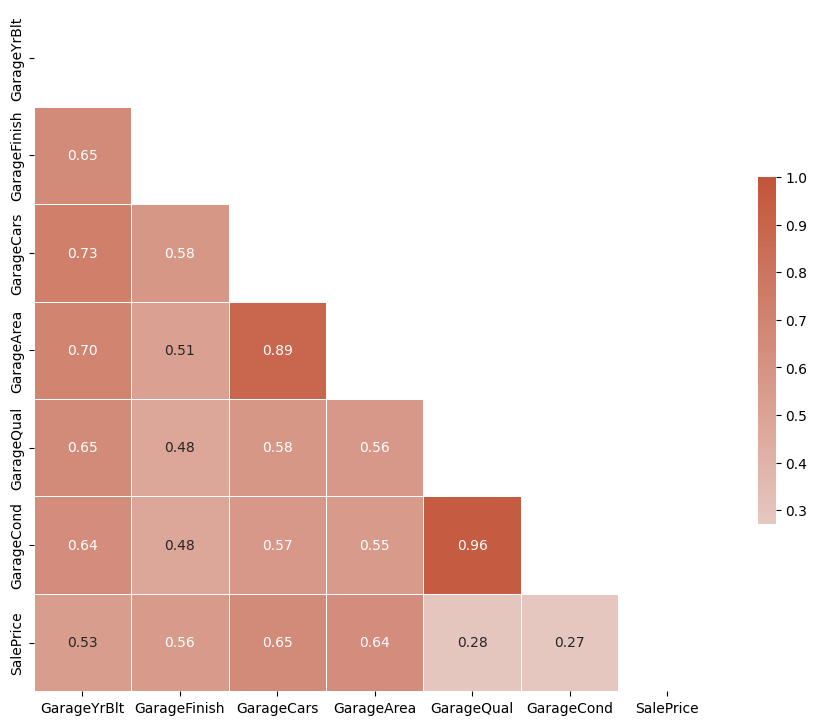

In [ ]:
garage_cols = ['GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'SalePrice']

corr = df[garage_cols].corr()
plot_heatmap(corr)


Primeiramente, observamos que há correlação muito forte entre GarageArea e GarageCars, como também entre GarageQual e GarageCond. Iremos unir essas features. Caso a nova feature tenha MI Score superior, removeremos as features originais.

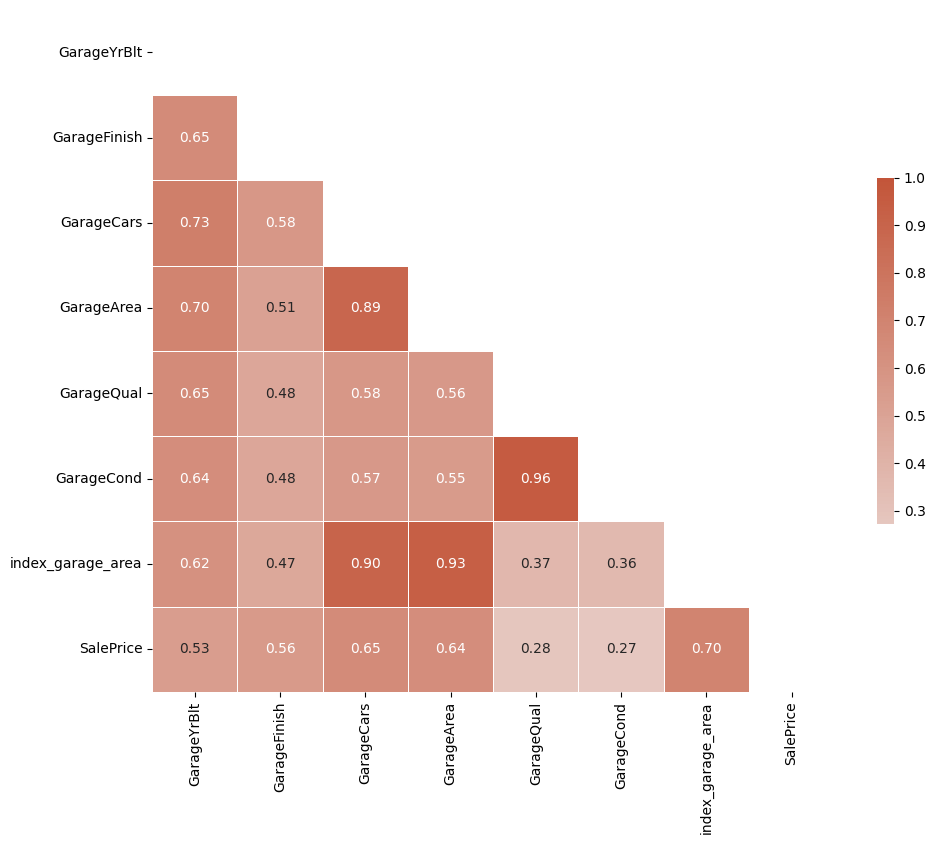

In [ ]:
df['index_garage_area'] = np.nan_to_num(df.GarageArea * df.GarageCars * df.GarageCond)


garage_cols = ['GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'index_garage_area', 'SalePrice']
plot_heatmap(df[garage_cols].corr())

In [ ]:
adicionar_caracteristicas_fortemente_correlacionadas('GarageArea')
adicionar_caracteristicas_fortemente_correlacionadas('GarageCars')
adicionar_caracteristicas_fortemente_correlacionadas('GarageCond')

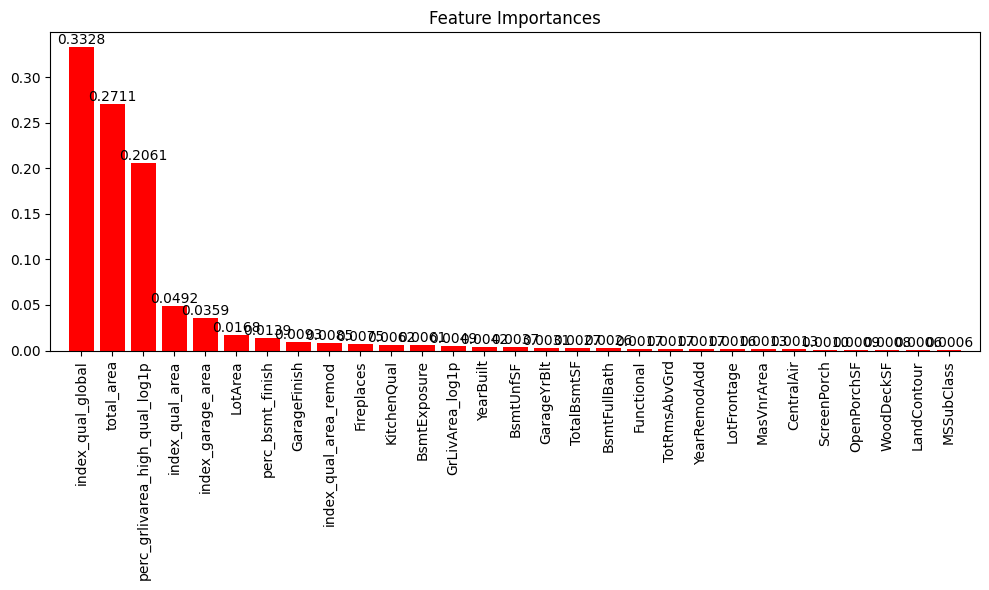

                                MIScore  Pearson  Spearman
total_area                       0.6564   0.8181    0.8144
index_qual_global                0.6211   0.8197    0.8313
perc_grlivarea_high_qual_log1p   0.6205   0.7384    0.8054
GrLivArea_log1p                  0.4900   0.6996    0.7303
index_qual_area                  0.4744   0.3445    0.7699
index_qual_area_remod            0.3991   0.3504    0.6967
index_garage_area                0.3926   0.6965    0.6732
YearBuilt                        0.3652   0.5360    0.6524
TotalBsmtSF                      0.3641   0.6388    0.5996
KitchenQual                      0.3253   0.6660    0.6712
GarageYrBlt                      0.3145   0.5324    0.6340
MSSubClass                       0.2765  -0.0836    0.0096
GarageFinish                     0.2661   0.5584    0.6332
YearRemodAdd                     0.2534   0.5229    0.5722
FullBath                         0.2522   0.5583    0.6334
TotRmsAbvGrd                     0.2071   0.5335    0.52

In [ ]:
plot_stats_features(df=df, num_features=29, remover_colunas_altamente_correlacionadas=True)

In [ ]:
# d = avaliar_modelos_em_validacao_cruzada(X=df[feature_importance_cols], y=df['SalePrice'])

################################  STATS (29 Features) ########################################

                          models  score    std  r2_score
2      GradientBoostingRegressor 0.1231 0.0133    0.9075
4                  LGBMRegressor 0.1248 0.0114    0.8989
6  HistGradientBoostingRegressor 0.1251 0.0119    0.9004
1            ExtraTreesRegressor 0.1270 0.0155    0.9019
0          RandomForestRegressor 0.1292 0.0144    0.9003
5                   XGBRegressor 0.1297 0.0111    0.8867
7               BaggingRegressor 0.1329 0.0142    0.8963
3              AdaBoostRegressor 0.1743 0.0227    0.8467

##### BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, TotRmsAbvGrd

dataframe['total_full_half_bathroom_ponderados'] = dataframe['FullBath'] + 0.5 * dataframe['HalfBath'] + dataframe['BsmtFullBath'] + 0.5 * dataframe['BsmtHalfBath']

In [ ]:
rooms = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd']

df['gr_liv_area_per_rooms_abgr'] = df.GrLivArea / df.TotRmsAbvGrd
df['bedrooms_per_totalrooms'] = df.BedroomAbvGr / df.TotRmsAbvGrd
df['total_bath_rooms'] = df.BsmtFullBath * 2 + df.BsmtHalfBath + df.FullBath * 2 + df.HalfBath
df['total_full_half_bathroom_ponderados'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']

adicionar_caracteristicas_fortemente_correlacionadas('TotalBsmtSF')

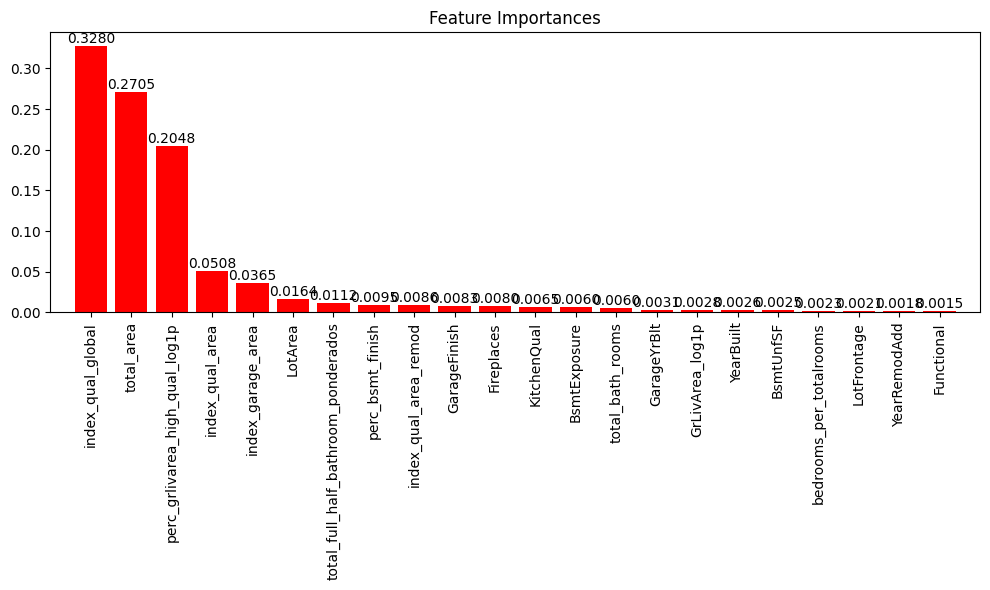

                                     MIScore  Pearson  Spearman
total_area                            0.6596   0.8181    0.8144
index_qual_global                     0.6318   0.8197    0.8313
perc_grlivarea_high_qual_log1p        0.6181   0.7384    0.8054
GrLivArea_log1p                       0.4901   0.6996    0.7303
index_qual_area                       0.4773   0.3445    0.7699
index_qual_area_remod                 0.3943   0.3504    0.6967
index_garage_area                     0.3886   0.6965    0.6732
YearBuilt                             0.3557   0.5360    0.6524
total_full_half_bathroom_ponderados   0.3494   0.6360    0.7023
total_bath_rooms                      0.3391   0.6360    0.7023
KitchenQual                           0.3253   0.6660    0.6712
GarageYrBlt                           0.3134   0.5324    0.6340
MSSubClass                            0.2676  -0.0836    0.0096
GarageFinish                          0.2669   0.5584    0.6332
gr_liv_area_per_rooms_abgr            0.

In [ ]:
plot_stats_features(df=df, remover_colunas_altamente_correlacionadas=True, num_features=22)

In [ ]:
# d = avaliar_modelos_em_validacao_cruzada(X=df[feature_importance_cols], y=df['SalePrice'])

################################  STATS 22 features ########################################

                          models  score    std  r2_score
2      GradientBoostingRegressor 0.1223 0.0123    0.9118
6  HistGradientBoostingRegressor 0.1257 0.0124    0.9052
4                  LGBMRegressor 0.1260 0.0133    0.9038
0          RandomForestRegressor 0.1273 0.0143    0.9083
1            ExtraTreesRegressor 0.1276 0.0143    0.9090
5                   XGBRegressor 0.1286 0.0100    0.8983
7               BaggingRegressor 0.1289 0.0163    0.8965
3              AdaBoostRegressor 0.1718 0.0200    0.8531

##### LotArea e LotFrontage

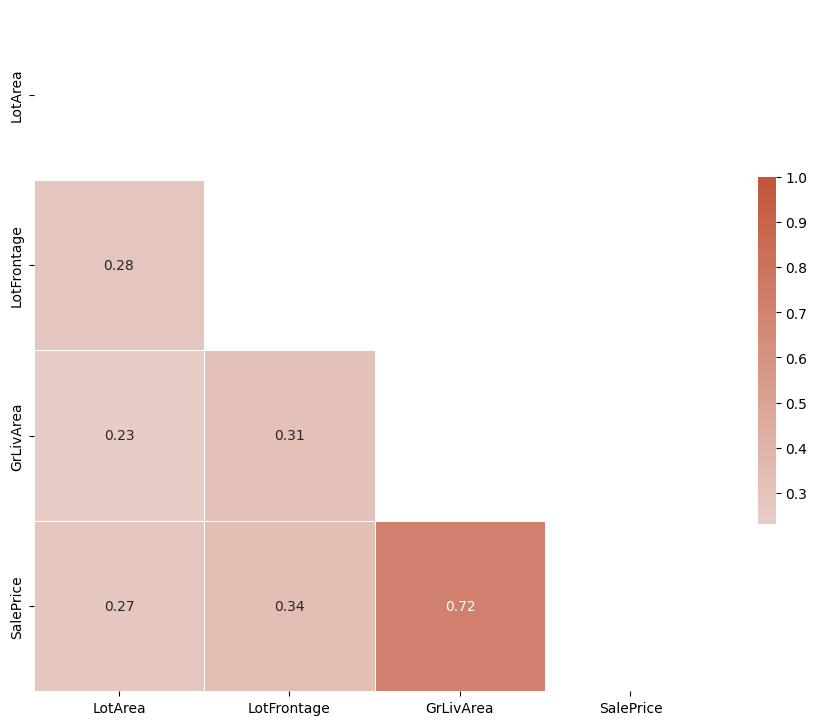

In [ ]:
plot_heatmap(df[['LotArea', 'LotFrontage', 'GrLivArea', 'SalePrice']].corr())

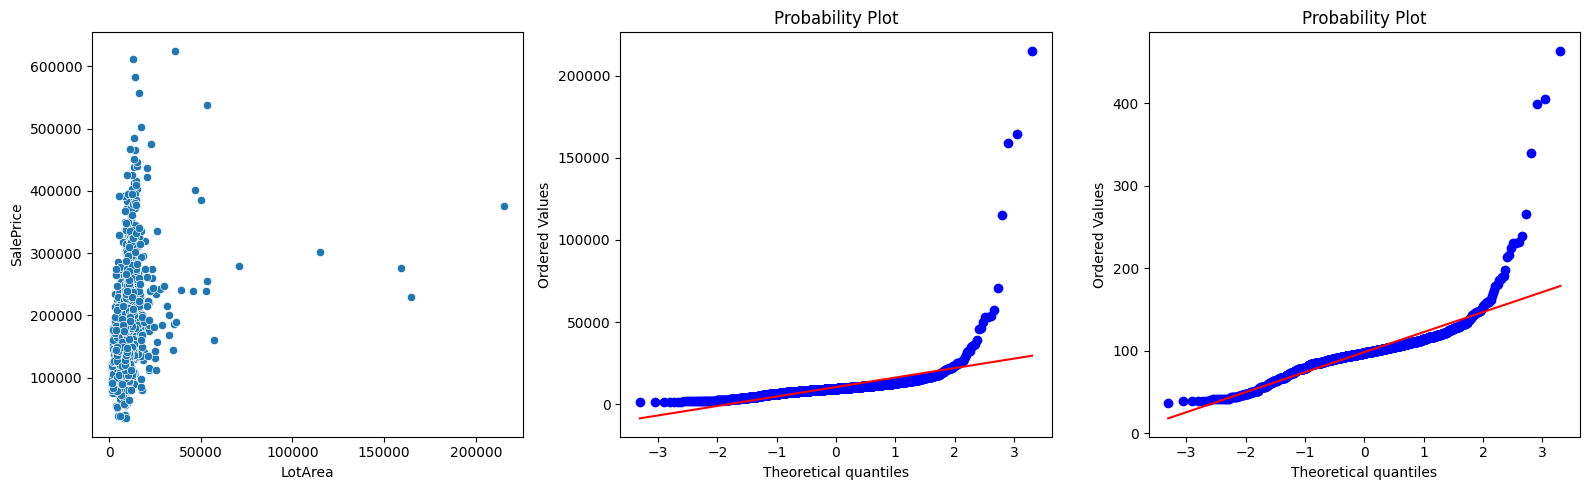

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
sns.scatterplot(data=df, x='LotArea', y='SalePrice', ax=axes[0])
stats.probplot(df['LotArea'], dist=stats.norm, plot=axes[1])
stats.probplot(np.sqrt(df['LotArea']), dist=stats.norm, plot=axes[2])
plt.tight_layout()
plt.show()


In [ ]:
outliers = df[df.LotArea > 100000]
df.iloc[outliers.index]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,Fence,MiscFeature,MiscVal,YrSold,SaleType,SaleCondition,SalePrice,SalePrice_log1p,GrLivArea_log1p,perc_grlivarea_high_qual,perc_grlivarea_high_qual_log1p,perc_bsmt_finish,total_area,index_qual_global,index_cond_global,age_house,age_remode,index_qual_area,index_qual_area_remod,index_garage_area,gr_liv_area_per_rooms_abgr,bedrooms_per_totalrooms,total_bath_rooms,total_full_half_bathroom_ponderados
249,250,50,RL,68.9862,159000,0,2,1,5,1,ClearCr,Norm,Norm,1Fam,1.5Fin,6.0000,7,1958,2006,Gable,CompShg,Wd Sdng,HdBoard,BrkCmn,472.0000,4,4,CBlock,4,3,4,Rec,697.0000,Unf,0.0000,747.0000,1444.0000,GasA,4,1,5,2144,0.0000,1.0000,2,0,4,1,4,7,8,2,Attchd,1958.0000,3,2.0000,389.0000,3,3,3,0,98,0,0,NA,Shed,500,2007,WD,Normal,277000.0000,12.5318,7.6709,90048.0000,11.4081,61.7839,3588.0000,14.0000,14,49.0000,1.0000,7.3347,359.3995,2334.0000,306.2857,0.5714,5.0000,2.5000
313,314,20,RL,150.0000,215245,0,1,1,1,1,Timber,Norm,Norm,1Fam,1Story,7.0000,7,1965,1965,Hip,CompShg,BrkFace,BrkFace,None,0.0000,3,4,CBlock,4,3,4,ALQ,1236.0000,Rec,820.0000,80.0000,2136.0000,GasW,3,1,5,2036,2.0000,0.0000,2,0,3,1,3,8,8,2,Attchd,1965.0000,2,2.0000,513.0000,3,3,3,0,0,0,0,NA,NA,0,2009,WD,Normal,375000.0000,12.8347,7.6192,71260.0000,11.1741,123.2060,4172.0000,14.0000,14,44.0000,44.0000,10.2758,10.2758,3078.0000,254.5000,0.3750,8.0000,4.0000
336,337,20,RL,86.0000,14157,0,3,2,3,3,StoneBr,Norm,Norm,1Fam,1Story,9.0000,7,2005,2006,Hip,CompShg,VinylSd,VinylSd,Stone,200.0000,4,4,PConc,5,3,4,GLQ,1249.0000,Unf,0.0000,673.0000,1922.0000,GasA,5,1,5,1922,1.0000,0.0000,2,0,3,1,4,8,8,1,Attchd,2005.0000,3,3.0000,676.0000,3,3,3,178,51,0,0,NA,NA,0,2007,WD,Normal,377426.0000,12.8411,7.5616,86490.0000,11.3678,166.3600,3844.0000,18.0000,14,2.0000,1.0000,279.0000,558.0000,6084.0000,240.2500,0.3750,6.0000,3.0000
711,712,50,C (all),66.0000,8712,1,4,2,1,2,IDOTRR,Norm,Norm,1Fam,1.5Fin,4.0000,7,1900,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0000,3,4,Stone,3,3,2,Unf,0.0000,Unf,0.0000,859.0000,859.0000,GasA,4,1,5,1178,0.0000,0.0000,1,0,2,1,3,7,8,0,Detchd,1964.0000,2,1.0000,384.0000,3,3,1,68,0,98,0,NA,NA,0,2010,WD,Abnorml,102776.0000,11.5403,7.0724,32984.0000,10.4038,0.0000,2037.0000,10.0000,14,110.0000,60.0000,1.6412,3.0089,1152.0000,168.2857,0.2857,2.0000,1.0000


In [ ]:
df.drop(index=outliers.index, inplace=True)

In [ ]:
df['diff_gr_liv_area_lot_area'] = (df.GrLivArea_log1p - np.log1p(df.LotArea)) / df.GrLivArea_log1p
df['lot_area_per_lot_frontage'] = df.LotArea / np.exp2(df.LotFrontage)

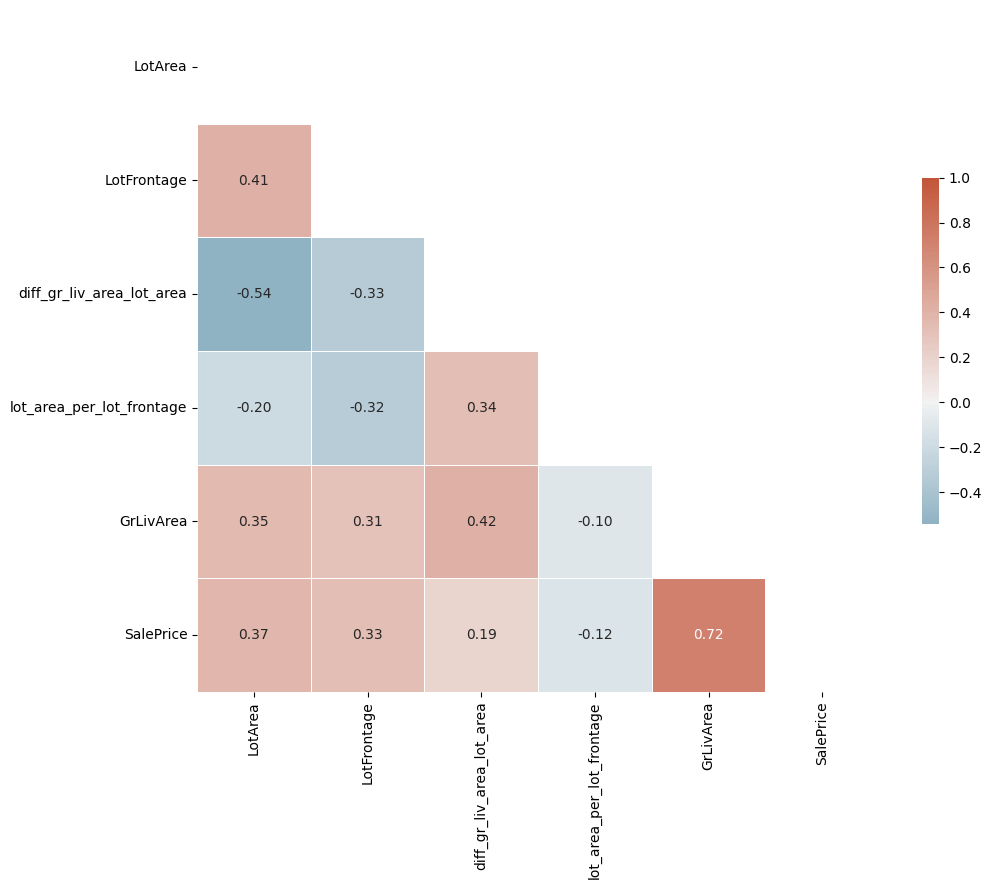

In [ ]:
plot_heatmap(df[['LotArea', 'LotFrontage', 'diff_gr_liv_area_lot_area', 'lot_area_per_lot_frontage', 'GrLivArea', 'SalePrice']].corr())

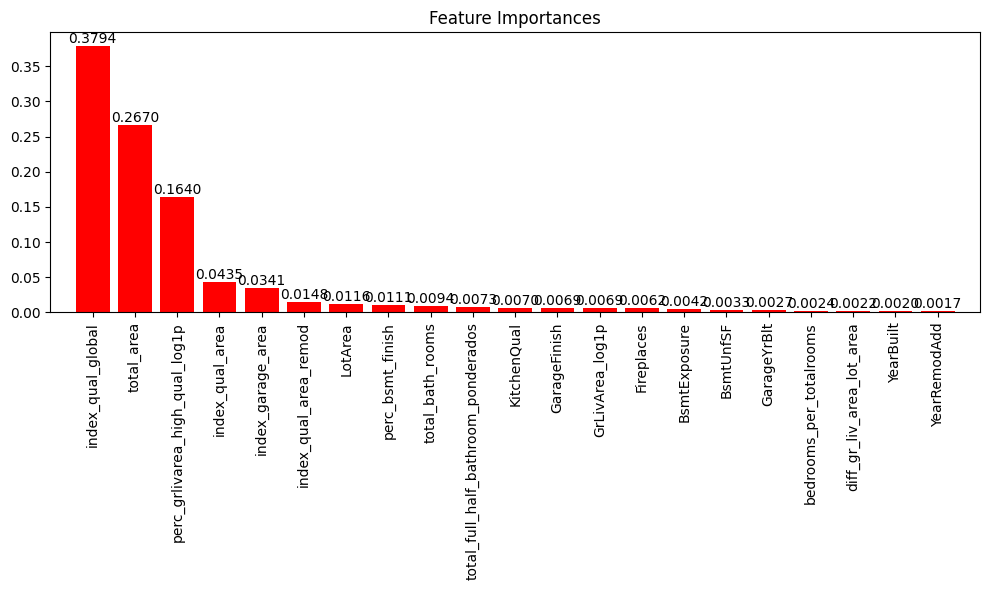

                                     MIScore  Pearson  Spearman
total_area                            0.6527   0.8170    0.8132
index_qual_global                     0.6200   0.8221    0.8330
perc_grlivarea_high_qual_log1p        0.6189   0.7387    0.8049
GrLivArea_log1p                       0.4850   0.6991    0.7292
index_qual_area                       0.4775   0.3470    0.7716
index_qual_area_remod                 0.3985   0.3525    0.6981
index_garage_area                     0.3926   0.6986    0.6739
YearBuilt                             0.3703   0.5390    0.6559
total_full_half_bathroom_ponderados   0.3363   0.6344    0.7012
total_bath_rooms                      0.3331   0.6344    0.7012
KitchenQual                           0.3184   0.6694    0.6734
GarageYrBlt                           0.3168   0.5358    0.6383
GarageFinish                          0.2801   0.5599    0.6342
MSSubClass                            0.2786  -0.0830    0.0109
YearRemodAdd                          0.

In [ ]:
plot_stats_features(df=df, num_features=21, remover_colunas_altamente_correlacionadas=True)

In [ ]:
# d = avaliar_modelos_em_validacao_cruzada(X=df[feature_importance_cols], y=df['SalePrice'])

################################  STATS 21 Features ########################################

                          models  score    std  r2_score
2      GradientBoostingRegressor 0.1216 0.0133    0.9104
6  HistGradientBoostingRegressor 0.1253 0.0124    0.9042
4                  LGBMRegressor 0.1253 0.0124    0.9062
1            ExtraTreesRegressor 0.1263 0.0142    0.9082
0          RandomForestRegressor 0.1281 0.0151    0.9066
5                   XGBRegressor 0.1284 0.0085    0.9028
7               BaggingRegressor 0.1314 0.0130    0.9019

##### explorando

In [ ]:
df['total_area_freq'] = df.groupby(by=['index_qual_global'])['total_area'].transform('mean')
df = adicionar_preco_metro_quadrado(dataframe=df)
df['foundation_count'] = df.groupby(by=['MSSubClass', 'MSZoning'])['Id'].transform('count')

# df = create_smoothed_price_per_sq_meter_feature(df=df, categorical_columns=['Neighborhood', 'OverallQual'], target_column='SalePrice', area_column='total_area')

In [ ]:

df['foundation_count']

0       269
1       503
2       269
3        30
4       269
       ... 
1444    269
1445    503
1446     30
1447    503
1448    503
Name: foundation_count, Length: 1449, dtype: int64

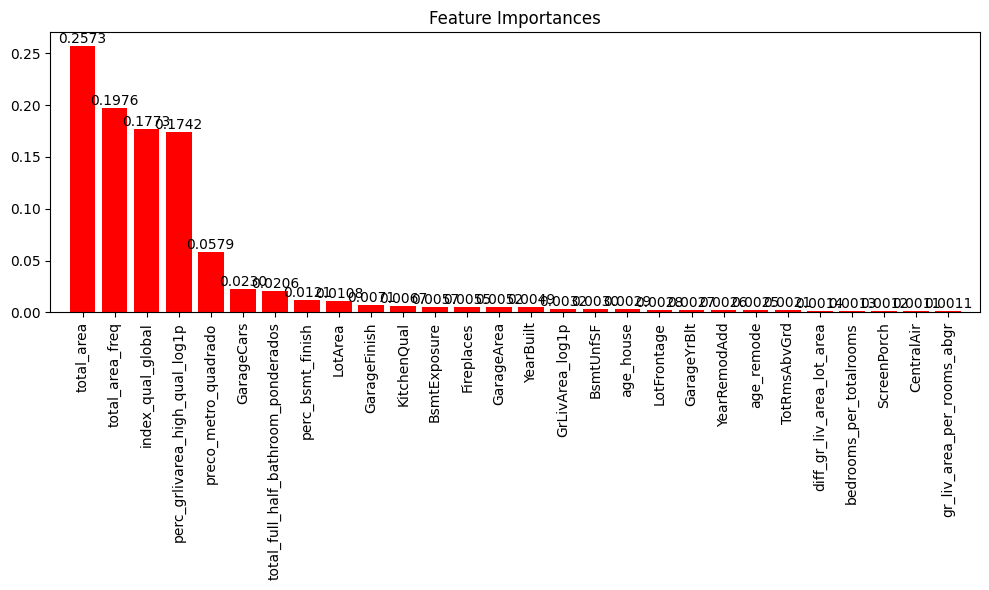

                                     MIScore  Pearson  Spearman
total_area                            0.6568   0.8181    0.8144
perc_grlivarea_high_qual_log1p        0.6190   0.7384    0.8054
index_qual_global                     0.6166   0.8197    0.8313
total_area_freq                       0.6098   0.8370    0.8313
preco_metro_quadrado                  0.4939   0.6904    0.7346
GrLivArea_log1p                       0.4866   0.6996    0.7303
GarageArea                            0.3699   0.6403    0.6480
YearBuilt                             0.3582   0.5360    0.6524
GarageCars                            0.3579   0.6509    0.6888
total_bath_rooms                      0.3447   0.6360    0.7023
total_full_half_bathroom_ponderados   0.3417   0.6360    0.7023
age_house                             0.3392  -0.5362   -0.6500
KitchenQual                           0.3175   0.6660    0.6712
GarageYrBlt                           0.3076   0.5324    0.6340
MSSubClass                            0.

In [585]:
plot_stats_features(df=df, num_features=28, remover_colunas_altamente_correlacionadas=True)

In [587]:
df[feature_importance_cols]

,total_area,total_area_freq,index_qual_global,perc_grlivarea_high_qual_log1p,preco_metro_quadrado,GarageCars,total_full_half_bathroom_ponderados,perc_bsmt_finish,LotArea,GarageFinish,KitchenQual,BsmtExposure,Fireplaces,GarageArea,YearBuilt,GrLivArea_log1p,BsmtUnfSF,age_house,LotFrontage,GarageYrBlt,YearRemodAdd,age_remode,TotRmsAbvGrd,diff_gr_liv_area_lot_area,bedrooms_per_totalrooms,ScreenPorch,CentralAir,gr_liv_area_per_rooms_abgr
0,2566.0000,2777.7186,15.0000,10.9996,75.2063,2.0000,3.5000,105.5701,8450,2,4,1,0,548.0000,2003,7.4448,150.0000,5.0000,81.0066,2003.0000,2003,5.0000,8,-0.2145,0.3750,0,1,213.7500
1,2524.0000,2496.3859,13.0000,11.0117,82.0862,2.0000,2.5000,99.1949,9600,2,3,4,1,460.0000,1976,7.1412,284.0000,31.0000,84.2643,1976.0000,1976,31.0000,6,-0.2840,0.5000,0,1,210.3333
2,2706.0000,2777.7186,15.0000,11.0431,75.2063,2.0000,3.5000,67.6174,11250,2,4,2,1,608.0000,2001,7.4883,434.0000,7.0000,39.9606,2001.0000,2002,6.0000,6,-0.2457,0.5000,0,1,297.6667
3,2473.0000,2496.3859,13.0000,11.0037,74.7848,3.0000,2.0000,36.5714,9550,1,4,1,1,642.0000,1915,7.4489,540.0000,91.0000,88.2227,1998.0000,1970,36.0000,7,-0.2303,0.4286,0,1,245.2857
4,3343.0000,3254.4409,16.0000,11.3842,82.6736,3.0000,3.5000,73.2227,14260,2,4,3,1,836.0000,2000,7.6958,490.0000,8.0000,83.8261,2000.0000,2000,8.0000,9,-0.2429,0.4444,0,1,244.2222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2600.0000,2496.3859,13.0000,10.8079,77.3623,2.0000,2.5000,0.0000,7917,2,3,1,1,460.0000,1999,7.4073,953.0000,8.0000,62.0000,1999.0000,2000,7.0000,7,-0.2119,0.4286,0,1,235.2857
1456,3615.0000,2496.3859,13.0000,11.2203,66.3933,2.0000,3.0000,79.1077,13175,1,3,1,2,500.0000,1978,7.6372,589.0000,32.0000,85.0000,1978.0000,1988,22.0000,7,-0.2421,0.4286,0,1,296.1429
1457,3492.0000,2777.7186,15.0000,11.9010,74.7848,1.0000,2.0000,30.5556,9042,2,4,1,2,252.0000,1941,7.7583,877.0000,69.0000,66.0000,1941.0000,2006,4.0000,9,-0.1742,0.4444,0,1,260.0000
1458,2156.0000,2228.0571,11.0000,10.3841,64.8517,1.0000,2.0000,64.0000,9717,1,4,2,0,240.0000,1950,6.9838,0.0000,60.0000,68.0000,1950.0000,1996,14.0000,5,-0.3147,0.4000,0,1,215.6000


In [588]:
d = avaliar_modelos_em_validacao_cruzada(X=df[feature_importance_cols], y=df.SalePrice)


################################  STATS ########################################

                          models  score    std  r2_score
2      GradientBoostingRegressor 0.1219 0.0141    0.9131
5  HistGradientBoostingRegressor 0.1229 0.0146    0.9062
3                  LGBMRegressor 0.1236 0.0147    0.9063
1            ExtraTreesRegressor 0.1245 0.0182    0.9079
0          RandomForestRegressor 0.1265 0.0155    0.9067
6               BaggingRegressor 0.1295 0.0149    0.9008
4                   XGBRegressor 0.1326 0.0131    0.8920



################################  STATS 28 features ########################################

                          models  score    std  r2_score
2      GradientBoostingRegressor 0.1178 0.0134    0.9170
5  HistGradientBoostingRegressor 0.1211 0.0114    0.9087
3                  LGBMRegressor 0.1212 0.0113    0.9088
4                   XGBRegressor 0.1225 0.0107    0.8955
1            ExtraTreesRegressor 0.1230 0.0174    0.9091
0          RandomForestRegressor 0.1250 0.0139    0.9112
6               BaggingRegressor 0.1265 0.0113    0.9022

In [589]:
df, teste = obter_dataframe_processado()

d = avaliar_modelos_em_validacao_cruzada(X=df[feature_importance_cols], y=df.SalePrice)

Feature perc_grlivarea_high_qual já existe
Feature GrLivArea já existe
Feature BsmtFinSF1 já existe
Feature BsmtFinSF2 já existe
Feature OverallQual já existe
Feature ExterQual já existe
Feature BsmtQual já existe
Feature OverallCond já existe
Feature ExterCond já existe
Feature BsmtCond já existe
Feature TotalBsmtSF já existe

################################  STATS ########################################

                          models  score    std  r2_score
2      GradientBoostingRegressor 0.1222 0.0141    0.9134
1            ExtraTreesRegressor 0.1227 0.0180    0.9062
5  HistGradientBoostingRegressor 0.1229 0.0146    0.9062
3                  LGBMRegressor 0.1236 0.0147    0.9063
0          RandomForestRegressor 0.1259 0.0152    0.9061
6               BaggingRegressor 0.1302 0.0166    0.9006
4                   XGBRegressor 0.1326 0.0131    0.8920


Em linhas gerais, o cluster incrementou a performance utilizando as top 10 features numéricas. Porém, há uma grande variabilidade de preços dentro de um mesmo cluster. 

## Tunning

In [233]:
df, teste = obter_dataframe_processado()

Feature perc_grlivarea_high_qual já existe
Feature GrLivArea já existe
Feature BsmtFinSF1 já existe
Feature BsmtFinSF2 já existe
Feature OverallQual já existe
Feature ExterQual já existe
Feature BsmtQual já existe
Feature OverallCond já existe
Feature ExterCond já existe
Feature BsmtCond já existe
Feature TotalBsmtSF já existe


In [ ]:
avaliar_modelos_em_validacao_cruzada(X=df[feature_importance_cols], y=df.SalePrice)

In [235]:
feature_importance_cols

[]

In [234]:
Xtreino, XTeste, ytreino, yteste = train_test_split(df[feature_importance_cols], df['SalePrice'], test_size=0.3, random_state=42)

In [147]:
# import numpy as np
# from sklearn.metrics import mean_squared_error
# from bayes_opt import BayesianOptimization
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.model_selection import KFold

# def log_rmse_tunning(y_true, y_pred):
#     # Verificar a presença de valores infinitos e NaN
#     assert not np.any(np.isinf(y_true)) and not np.any(np.isinf(y_pred)), "Valores infinitos encontrados"
#     assert not np.any(np.isnan(y_true)) and not np.any(np.isnan(y_pred)), "Valores NaN encontrados"
    
#     # Substituir valores zero ou negativos por um pequeno valor positivo para evitar logaritmos inválidos
#     y_true = np.maximum(y_true, 1e-9)
#     y_pred = np.maximum(y_pred, 1e-9)

#     # Calcular o log_rmse
#     log_y_true = np.log(y_true)
#     log_y_pred = np.log(y_pred)
    
#     score = np.sqrt(mean_squared_error(log_y_true, log_y_pred))
#     return score

# # Função de avaliação utilizando log_rmse
# def gb_evaluate(learning_rate, n_estimators, max_depth, min_samples_split, min_samples_leaf, subsample):
#     params = {
#         'learning_rate': learning_rate,
#         'n_estimators': int(n_estimators),  # Convertendo para inteiro
#         'max_depth': int(max_depth),        # Convertendo para inteiro
#         'min_samples_split': int(min_samples_split),  # Convertendo para inteiro
#         'min_samples_leaf': int(min_samples_leaf),    # Convertendo para inteiro
#         'subsample': subsample
#     }
    
#     # Inicializar o modelo com os parâmetros
#     model = GradientBoostingRegressor(**params)

#     # Definir o KFold para a validação cruzada
#     kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     log_rmse_scores = []
    
#     for train_index, test_index in kf.split(df[feature_importance_cols]):
#         X_train_cv, X_valid_cv = df.iloc[train_index][feature_importance_cols], df.iloc[test_index][feature_importance_cols]
#         y_train_cv, y_valid_cv = df.iloc[train_index].SalePrice_log1p, df.iloc[test_index].SalePrice_log1p
        
#         model.fit(X_train_cv, y_train_cv)
#         y_pred_cv = model.predict(X_valid_cv)
#         log_rmse_scores.append(log_rmse_tunning(y_valid_cv, y_pred_cv))
    
#     # Retorna o negativo da média do log_rmse para maximizar na otimização
#     return -np.mean(log_rmse_scores)

# # Espaço de busca para os hiperparâmetros
# param_bounds = {
#     'learning_rate': (0.00001, 0.3),
#     'n_estimators': (50, 500),
#     'max_depth': (3, 10),
#     'min_samples_split': (2, 10),
#     'min_samples_leaf': (1, 10),
#     'subsample': (0.5, 1.0)
# }

# # Inicializar o otimizador bayesiano
# optimizer = BayesianOptimization(
#     f=gb_evaluate,
#     pbounds=param_bounds,
#     random_state=42,
#     verbose=2
# )

# # Executar a otimização
# optimizer.maximize(
#     init_points=10,  # Número de pontos de partida aleatórios
#     n_iter=50        # Número de iterações de otimização
# )

# # Obter os melhores parâmetros
# print(optimizer.max)

|   iter    |  target   | learni... | max_depth | min_sa... | min_sa... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | -0.01033  | 0.1124    | 9.655     | 7.588     | 6.789     | 120.2     | 0.578     |
| 2         | -0.01585  | 0.01743   | 9.063     | 6.41      | 7.665     | 59.26     | 0.985     |
| 3         | -0.01057  | 0.2497    | 4.486     | 2.636     | 3.467     | 186.9     | 0.7624    |
| 4         | -0.01016  | 0.1296    | 5.039     | 6.507     | 3.116     | 181.5     | 0.6832    |
| 5         | -0.01053  | 0.1368    | 8.496     | 2.797     | 6.114     | 316.6     | 0.5232    |
| 6         | -0.01034  | 0.1823    | 4.194     | 1.585     | 9.591     | 484.5     | 0.9042    |
| 7         | -0.009861 | 0.09139   | 3.684     | 7.158     | 5.521     | 104.9     | 0.7476    |
| 8         | -0.01133  | 0.01033   | 9.365     | 3.329     | 7.3       | 190.3     | 0.76      |
| 9         | -0.010

{'target': np.float64(-0.11828374164634314), 'params': {'learning_rate': np.float64(0.04353845915449018), 'max_depth': np.float64(7.143069017549528), 'min_samples_leaf': np.float64(5.843476826210728), 'min_samples_split': np.float64(4.255266524126264), 'n_estimators': np.float64(142.80750949806188), 'subsample': np.float64(0.718046648663696)}}

{'target': np.float64(-0.009732878943915719), 'params': {'learning_rate': np.float64(0.1488467637704299), 'max_depth': np.float64(3.832218157912032), 'min_samples_leaf': np.float64(2.016696020538343), 'min_samples_split': np.float64(5.489386112858792), 'n_estimators': np.float64(109.59051866071184), 'subsample': np.float64(0.7726261590377127)}}

## Submit

In [590]:
tuned_params = {
    'learning_rate': 0.04353845915449018,
    'max_depth': int(7.143069017549528), 
    'min_samples_leaf': int(5.843476826210728),  
    'min_samples_split': int(4.255266524126264), 
    'n_estimators': int(142.80750949806188),  
    'subsample': 0.718046648663696
}

# Inicializando o modelo com os parâmetros ajustados
clf = GradientBoostingRegressor(**tuned_params)

# Ajustando o modelo com os dados de treino
clf.fit(df[feature_importance_cols], df.SalePrice)

GradientBoostingRegressor(learning_rate=0.04353845915449018, max_depth=7,
                          min_samples_leaf=5, min_samples_split=4,
                          n_estimators=142, subsample=0.718046648663696)

In [ ]:
pred = clf.predict(teste[feature_importance_cols])

d = {'Id': teste['Id'], 'SalePrice': pred}
submit = pd.DataFrame.from_dict(d)
submit.to_csv('prediction.csv', index=False)